### Pairs Trading Analysis

In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set(style="whitegrid")

In [2]:
df = pd.read_csv('final_data_10s.csv')


**Data Understanding:**

Let us first observe what the data types are first and ensure they are correct.
df.dtypes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737739 entries, 0 to 737738
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Time       737739 non-null  object 
 1   X_BID      737739 non-null  float64
 2   X_BID_VOL  737739 non-null  float64
 3   X_ASK      737739 non-null  float64
 4   X_ASK_VOL  737739 non-null  float64
 5   Y_BID      737739 non-null  float64
 6   Y_BID_VOL  737739 non-null  float64
 7   Y_ASK      737739 non-null  float64
 8   Y_ASK_VOL  737739 non-null  float64
dtypes: float64(8), object(1)
memory usage: 50.7+ MB


Notice that the time column is an object which is not what we want, so lets convert this type to datetime type

In [4]:
df['Time'] = pd.to_datetime(df['Time'])
df.head()

,Time,X_BID,X_BID_VOL,X_ASK,X_ASK_VOL,Y_BID,Y_BID_VOL,Y_ASK,Y_ASK_VOL
0,2019-11-18 08:00:00,106340.0,15.0,106348.0,11.0,105200.0,9.0,105210.0,19.0
1,2019-11-18 08:00:10,106312.0,6.0,106320.0,9.0,105180.0,5.0,105190.0,13.0
2,2019-11-18 08:00:20,106312.0,7.0,106320.0,12.0,105170.0,32.0,105180.0,1.0
3,2019-11-18 08:00:30,106336.0,22.0,106340.0,1.0,105190.0,10.0,105200.0,19.0
4,2019-11-18 08:00:40,106352.0,2.0,106356.0,4.0,105200.0,29.0,105220.0,24.0


For sanity check, check whether there are null or empty values in columns.

In [5]:
df.isna().sum()

Time         0
X_BID        0
X_BID_VOL    0
X_ASK        0
X_ASK_VOL    0
Y_BID        0
Y_BID_VOL    0
Y_ASK        0
Y_ASK_VOL    0
dtype: int64

We also note from the specification of the data that the ASK price is strictly larger than the BID price as to ensure no trades have been executed. So lets check if there exists any data point in which this discrepancy occurs.

In [6]:
bad_x = df[df['X_ASK'] <= df['X_BID']]

print(f"Number of X crossed/zero markets: {len(bad_x)}")
bad_x.head()

Number of X crossed/zero markets: 174


,Time,X_BID,X_BID_VOL,X_ASK,X_ASK_VOL,Y_BID,Y_BID_VOL,Y_ASK,Y_ASK_VOL
496271,2020-08-19 11:00:00,101132.0,5.0,101132.0,16.0,103100.0,5.0,103640.0,6.0
496272,2020-08-19 11:00:10,101132.0,5.0,101132.0,16.0,103100.0,5.0,103640.0,6.0
496273,2020-08-19 11:00:20,101132.0,5.0,101132.0,16.0,103100.0,5.0,103640.0,6.0
496274,2020-08-19 11:00:30,101132.0,5.0,101132.0,16.0,103100.0,5.0,103640.0,6.0
496275,2020-08-19 11:00:40,100616.0,18.0,100616.0,26.0,103370.0,3.0,103370.0,2.0


In [7]:
bad_y = df[df['Y_ASK'] <= df['Y_BID']]

print(f"Number of Y crossed/zero markets: {len(bad_y)}")
bad_y.head()

Number of Y crossed/zero markets: 170


,Time,X_BID,X_BID_VOL,X_ASK,X_ASK_VOL,Y_BID,Y_BID_VOL,Y_ASK,Y_ASK_VOL
496275,2020-08-19 11:00:40,100616.0,18.0,100616.0,26.0,103370.0,3.0,103370.0,2.0
496276,2020-08-19 11:00:50,100616.0,18.0,100616.0,26.0,103370.0,3.0,103370.0,2.0
496277,2020-08-19 11:01:00,100616.0,18.0,100616.0,26.0,103370.0,3.0,103370.0,2.0
496278,2020-08-19 11:01:10,100616.0,18.0,100616.0,26.0,103370.0,3.0,103370.0,2.0
496279,2020-08-19 11:01:20,100616.0,18.0,100616.0,26.0,103370.0,3.0,103370.0,2.0


In [8]:
#Mask to detect crossed/zero market discrepancies
crossed_any = (
    (df['X_ASK'] <= df['X_BID']) |
    (df['Y_ASK'] <= df['Y_BID'])
)

print(f"Any crossed markets: {crossed_any.any()}")
print(df[crossed_any])

Any crossed markets: True
                      Time     X_BID  X_BID_VOL     X_ASK  X_ASK_VOL  \
496271 2020-08-19 11:00:00  101132.0        5.0  101132.0       16.0   
496272 2020-08-19 11:00:10  101132.0        5.0  101132.0       16.0   
496273 2020-08-19 11:00:20  101132.0        5.0  101132.0       16.0   
496274 2020-08-19 11:00:30  101132.0        5.0  101132.0       16.0   
496275 2020-08-19 11:00:40  100616.0       18.0  100616.0       26.0   
...                    ...       ...        ...       ...        ...   
496440 2020-08-19 11:28:10  101212.0      102.0  101212.0      103.0   
496441 2020-08-19 11:28:20  101212.0      102.0  101212.0      103.0   
496442 2020-08-19 11:28:30  101212.0      102.0  101212.0      103.0   
496443 2020-08-19 11:28:40  101212.0      102.0  101212.0      103.0   
496444 2020-08-19 11:28:50  101212.0      102.0  101212.0      103.0   

           Y_BID  Y_BID_VOL     Y_ASK  Y_ASK_VOL  
496271  103100.0        5.0  103640.0        6.0  
496272 

There's an interesting observation that can be made here, we observe from the above that on the 19th Aug 2020 from 11 am to around 11:29 am, there are discrepancies where the ASK price is not stricly greater than the BID price for both instruments, meaning that a trade execution would've occured. Hence, these rows should be removed such to prevent contamination of data analysis. Additionally, from preliminary tests and experimentation on data, ![Spread Plot](spread_plot.png)


We can observe that on the weekends (days 5 and 6), the mean bid ask spread on instrument X is significantly larger and the mean rolling correlation is extremely small when compared to the other days. So it was deemed an outlier and removed from the data. Additionally, after carefully inspecting the weekends, I noticed that the bid/ask price and volumes for both of the instruments remained stagnant, indicating a non-trading period.

In [9]:
def weekend_stagnancy_report(df):
    d = df.copy()
    d["Time"] = pd.to_datetime(d["Time"])
    d = d.sort_values("Time")

    # Weekend subset (Sat=5, Sun=6)
    d["weekday"] = d["Time"].dt.dayofweek
    w = d[d["weekday"].isin([5, 6])].copy()

    cols = [
        ("X", "BID", "X_BID"),
        ("X", "ASK", "X_ASK"),
        ("X", "BID_VOL", "X_BID_VOL"),
        ("X", "ASK_VOL", "X_ASK_VOL"),
        ("Y", "BID", "Y_BID"),
        ("Y", "ASK", "Y_ASK"),
        ("Y", "BID_VOL", "Y_BID_VOL"),
        ("Y", "ASK_VOL", "Y_ASK_VOL"),
    ]

    def longest_constant_run(s):
        # counts longest streak of consecutive equal values
        same = s.eq(s.shift(1)).fillna(False).to_numpy()
        best = cur = 0
        for v in same:
            if v:
                cur += 1
                best = max(best, cur)
            else:
                cur = 0
        # run length in rows (include first element of streak)
        return best + 1 if best > 0 else 1

    rows = []
    for inst, kind, col in cols:
        if col not in w.columns:
            continue

        s = w[col]
        same_rate = s.eq(s.shift(1)).mean()  # fraction of rows unchanged vs previous
        longest_run = longest_constant_run(s)

        rows.append({
            "series": f"{inst}_{kind}",
            "n_rows_weekend": len(w),
            "unchanged_rate": float(same_rate),
            "longest_constant_run_rows": int(longest_run),
        })

    report = pd.DataFrame(rows).sort_values(["unchanged_rate", "longest_constant_run_rows"], ascending=False)
    return report, w

report, w = weekend_stagnancy_report(df)
display(report)

,series,n_rows_weekend,unchanged_rate,longest_constant_run_rows
3,X_ASK_VOL,209032,0.999799,18020
2,X_BID_VOL,209032,0.999775,10812
7,Y_ASK_VOL,209032,0.999751,10812
6,Y_BID_VOL,209032,0.999746,7208
4,Y_BID,209032,0.995101,3604
5,Y_ASK,209032,0.995101,3604
1,X_ASK,209032,0.994451,7208
0,X_BID,209032,0.994446,3604


Thus, the weekend data is not representative of an active market and should be removed prior to statistical modelling.

In [10]:
#removal:
df = df[df['X_ASK'] > df['X_BID']]
df = df[df['Y_ASK'] > df['Y_BID']]

df = df[df['Time'].dt.dayofweek < 5] #remove weekend

Check for duplication

In [11]:
df.loc[df.duplicated()]

,Time,X_BID,X_BID_VOL,X_ASK,X_ASK_VOL,Y_BID,Y_BID_VOL,Y_ASK,Y_ASK_VOL


Check for negative values

In [12]:
negative_value_exists = (df[['X_BID','X_BID_VOL','X_ASK','X_ASK_VOL','Y_BID','Y_BID_VOL','Y_ASK','Y_ASK_VOL']] < 0).any()
print(f"Any negatives?:\n{negative_value_exists}")

Any negatives?:
X_BID        False
X_BID_VOL    False
X_ASK        False
X_ASK_VOL    False
Y_BID        False
Y_BID_VOL    False
Y_ASK        False
Y_ASK_VOL    False
dtype: bool


## Detect periods of an inactive market
 The presence of weekends tells us that the presence of public holidays or other periods where there is no activity in the market should also be removed. Keeping these data would compromise our statistical analysis

In [13]:
d = df.sort_values('Time').copy()

quote_cols = [
    'X_BID','X_BID_VOL','X_ASK','X_ASK_VOL',
    'Y_BID','Y_BID_VOL','Y_ASK','Y_ASK_VOL'
]

# New run whenever any quote field changes
changed = (d[quote_cols] != d[quote_cols].shift(1)).any(axis=1)
d['run_id'] = changed.cumsum()

runs = (
    d.groupby('run_id')
     .agg(start=('Time','first'),
          end=('Time','last'),
          n_rows=('Time','size'))
)

runs['duration'] = runs['end'] - runs['start']


MIN_MINUTES = 1          # 1 minutes
MIN_ROWS = (MIN_MINUTES * 60) // 10   # rows needed

long_freezes = runs[runs['n_rows'] >= MIN_ROWS].sort_values('duration', ascending=False)

print(f"Threshold: {MIN_MINUTES} minutes => {MIN_ROWS} consecutive rows")
print(f"Long freezes found: {len(long_freezes)}")
print("\nTop 10 longest freezes:")
print(long_freezes.head(10))

# Add to original dataframe
freeze_runs = set(long_freezes.index)
d['is_frozen'] = d['run_id'].isin(freeze_runs)

# Summary
n_frozen = d['is_frozen'].sum()
pct_frozen = n_frozen / len(d) * 100


print(f"Total observations: {len(d):,}")
print(f"Frozen observations (≥{MIN_MINUTES} min): {n_frozen:,} ({pct_frozen:.2f}%)")
print(f"Active observations: {len(d) - n_frozen:,} ({100-pct_frozen:.2f}%)")

# Check what dates these are
if n_frozen > 0:
    frozen_dates = d[d['is_frozen']]['Time'].dt.date.value_counts().sort_index()
    print(f"\nDates with frozen periods:")
    print(frozen_dates)

# Update main dataframe
df = d.copy()

Threshold: 1 minutes => 6 consecutive rows
Long freezes found: 237

Top 10 longest freezes:
                     start                 end  n_rows        duration
run_id                                                                
81583  2020-01-27 09:12:10 2020-01-28 14:00:00    3171 1 days 04:47:50
488384 2020-12-24 11:00:00 2020-12-25 14:00:00    2883 1 days 03:00:00
47618  2019-12-25 08:02:00 2019-12-26 08:00:40    1795 0 days 23:58:40
52006  2019-12-31 13:04:10 2020-01-01 12:42:20    1672 0 days 23:38:10
386979 2020-10-01 13:47:50 2020-10-02 08:21:20     203 0 days 18:33:30
197045 2020-04-30 13:54:30 2020-05-01 08:02:40      51 0 days 18:08:10
47617  2019-12-24 13:59:50 2019-12-25 08:01:50      14 0 days 18:02:00
270708 2020-07-01 08:00:00 2020-07-01 14:00:00    1802 0 days 06:00:00
412240 2020-10-26 08:00:00 2020-10-26 13:09:50    1501 0 days 05:09:50
47633  2019-12-26 08:20:50 2019-12-26 13:26:40    1477 0 days 05:05:50
Total observations: 528,533
Frozen observations (≥1 min)

In [14]:
# REMOVE FROZEN PERIODS

# Before removal
print(f"Original observations: {len(df):,}")
print(f"Date range: {df['Time'].min()} to {df['Time'].max()}")

# Remove frozen rows
df_clean = df[~df['is_frozen']].copy() 

# After removal
print(f"Observations: {len(df_clean):,}")
print(f"Date range: {df_clean['Time'].min()} to {df_clean['Time'].max()}")
print(f"Removed: {len(df) - len(df_clean):,} observations ({(len(df) - len(df_clean))/len(df)*100:.2f}%)")

# Verify continuity
print(f"\nRemaining trading days: {df_clean['Time'].dt.date.nunique()}")

# Update working dataframe
df = df_clean.copy()


# Quick sanity check - no more long freezes
d_check = df.sort_values('Time').copy()
quote_cols = ['X_BID','X_BID_VOL','X_ASK','X_ASK_VOL','Y_BID','Y_BID_VOL','Y_ASK','Y_ASK_VOL']
changed = (d_check[quote_cols] != d_check[quote_cols].shift(1)).any(axis=1)
d_check['run_id'] = changed.cumsum()
runs_check = d_check.groupby('run_id').agg(n_rows=('Time','size'))
long_runs = runs_check[runs_check['n_rows'] >= 18]  # 3 min, 18 -> 180 seconds

print(f"\nSanity check - runs ≥3 min after cleaning: {len(long_runs)}")
if len(long_runs) == 0:
    print("No long frozen periods remain")
else:
    print(f"Still have {len(long_runs)} long runs - may need lower threshold")

Original observations: 528,533
Date range: 2019-11-18 08:00:00 to 2020-12-31 10:00:00
Observations: 494,671
Date range: 2019-11-18 08:00:00 to 2020-12-31 10:00:00
Removed: 33,862 observations (6.41%)

Remaining trading days: 289

Sanity check - runs ≥3 min after cleaning: 0
No long frozen periods remain


**Formulating the notion of Price Level**

Let us now look into anomaly detection. At first thought, using a midprice construction may seem suitable, however, upon observing the data, there exists high imbalances in the bid and ask volumes. For example, on 11/18/2019 8:00:30, the X_BID_VOL = 22 while X_ASK_VOL = 1. We must be able to address these imbalances.

At the same time, since we are just performing anomaly detection, it is best to utilise a relatively simple and intuitive notion of "fair value" of the instrument. Intuitively, a higher bid volume indicates strong buying interest, which theoretically pushes the "true" fair value closer to the ask price. So we implement the volume weighted average price:
$$ \text{VWAP}_t = \frac{ASK_t \cdot ASK\_VOL_t + BID_t \cdot BID\_VOL_t}{ASK\_VOL_t + BID\_VOL_t} $$


In [114]:
df['X_t'] = (df['X_ASK']*df["X_ASK_VOL"] + df['X_BID']*df['X_BID_VOL'])/(df['X_ASK_VOL'] + df["X_BID_VOL"])
df['X_spread'] = df['X_ASK'] - df['X_BID']

df['Y_t'] = (df['Y_ASK']*df["Y_ASK_VOL"] + df['Y_BID']*df['Y_BID_VOL'])/(df['Y_ASK_VOL'] + df["Y_BID_VOL"])
df['Y_spread'] = df['Y_ASK'] - df['Y_BID']

df['log_X'] = np.log(df['X_t'])
df['log_Y'] = np.log(df['Y_t'])




Let us now look at the first 100 observations of the bid ask spread of the X instrument in relation with the volume and price, just to gauge the data we are working with.

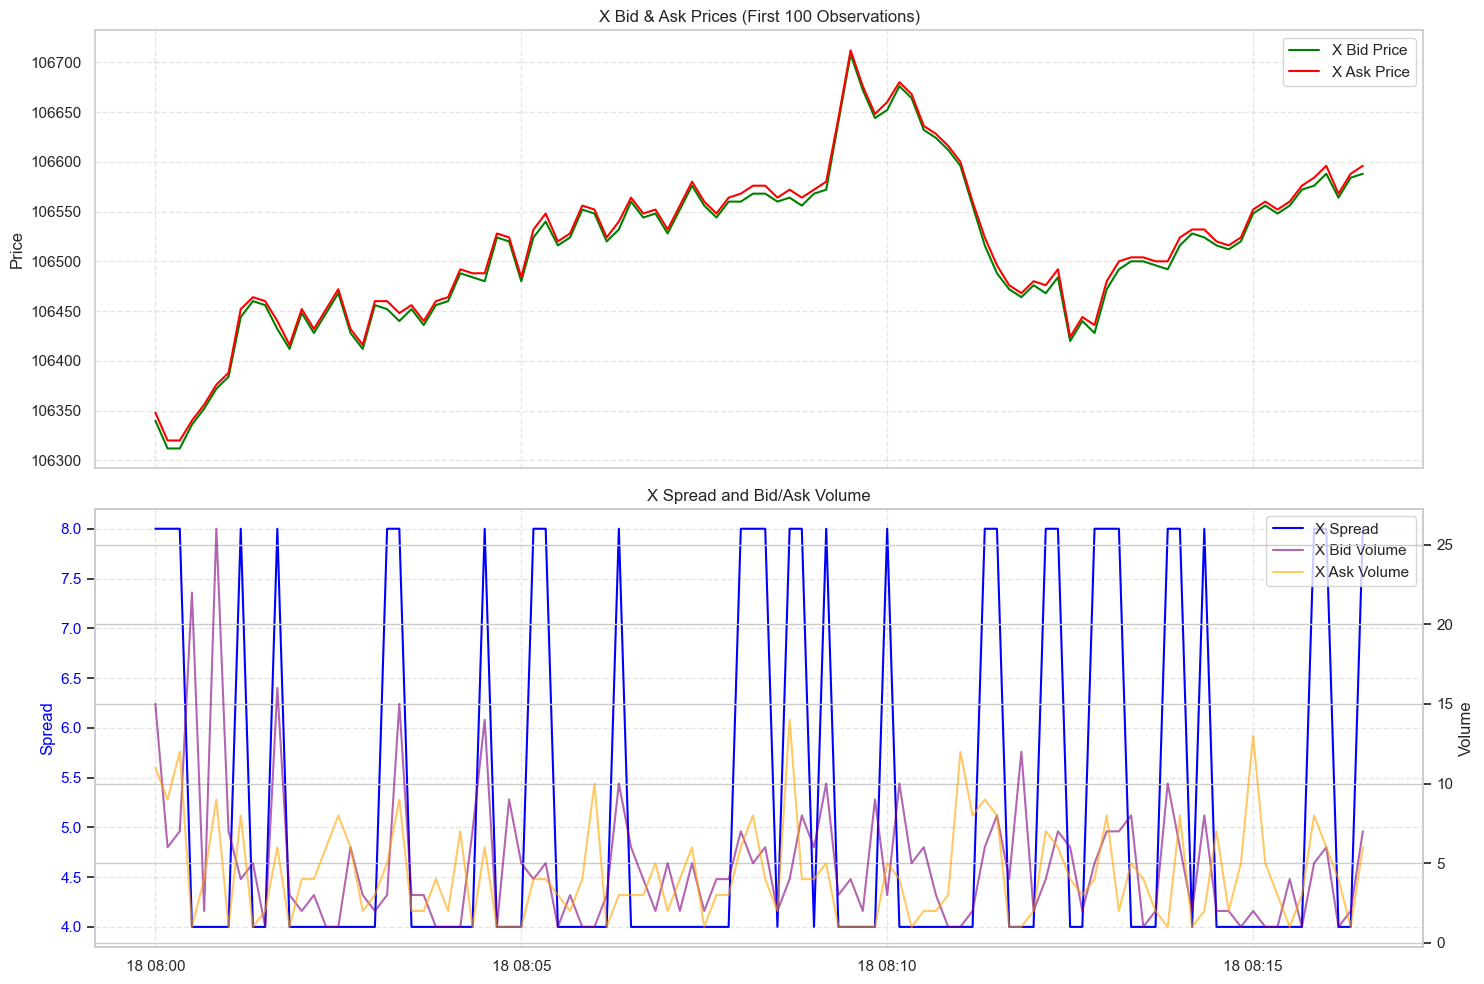

In [16]:
first_100 = df.iloc[:100]

fig, (ax_price, ax_spread) = plt.subplots(
    2, 1, figsize=(15, 10), sharex=True
)

# -------------------------
# TOP: Prices
# -------------------------
ax_price.plot(first_100['Time'],
              df['X_BID'].iloc[:100],
              color='green',
              label='X Bid Price')

ax_price.plot(first_100['Time'],
              df['X_ASK'].iloc[:100],
              color='red',
              label='X Ask Price')

ax_price.set_ylabel('Price')
ax_price.set_title('X Bid & Ask Prices (First 100 Observations)')
ax_price.legend()
ax_price.grid(True, linestyle='--', alpha=0.5)

# -------------------------
# BOTTOM: Spread + Volumes
# -------------------------
# Spread (left axis)
ax_spread.plot(first_100['Time'],
               first_100['X_spread'],
               color='blue',
               label='X Spread')

ax_spread.set_ylabel('Spread', color='blue')
ax_spread.tick_params(axis='y', labelcolor='blue')

# Volume (right axis)
ax_vol = ax_spread.twinx()

ax_vol.plot(first_100['Time'],
            df['X_BID_VOL'].iloc[:100],
            color='purple',
            alpha=0.6,
            label='X Bid Volume')

ax_vol.plot(first_100['Time'],
            df['X_ASK_VOL'].iloc[:100],
            color='orange',
            alpha=0.6,
            label='X Ask Volume')

ax_vol.set_ylabel('Volume')

# Combine legends
lines_1, labels_1 = ax_spread.get_legend_handles_labels()
lines_2, labels_2 = ax_vol.get_legend_handles_labels()

ax_spread.legend(lines_1 + lines_2,
                 labels_1 + labels_2,
                 loc='upper right')

ax_spread.set_title('X Spread and Bid/Ask Volume')
ax_spread.grid(True, linestyle='--', alpha=0.5)

plt.xlabel('Time')
plt.tight_layout()
plt.show()


It is quite interesting to observe hear that the bid ask spread of instrument X is bounded between $4 and $8. Surprisingly, this tells us the level of confidence that market makers/ participants have on what the "true" value of the price is. A possible strategy that could be investigated here is one where we may act as the market maker and decide to quote inside the existing spread, i.e $3 instead of $4 or $8. As such it is possible to simply profit from the spread capture instead of directional bets (investigated later). However, there are some challenges and limitations to this. For example, informed traders may fill our tighter quotes (adverse selection), we may accumulate unwanted positions during trending markets (inventory risk). This is a very interesting lens to the problem where may need to consider game theory principles, however it won't be studied further in this work. 



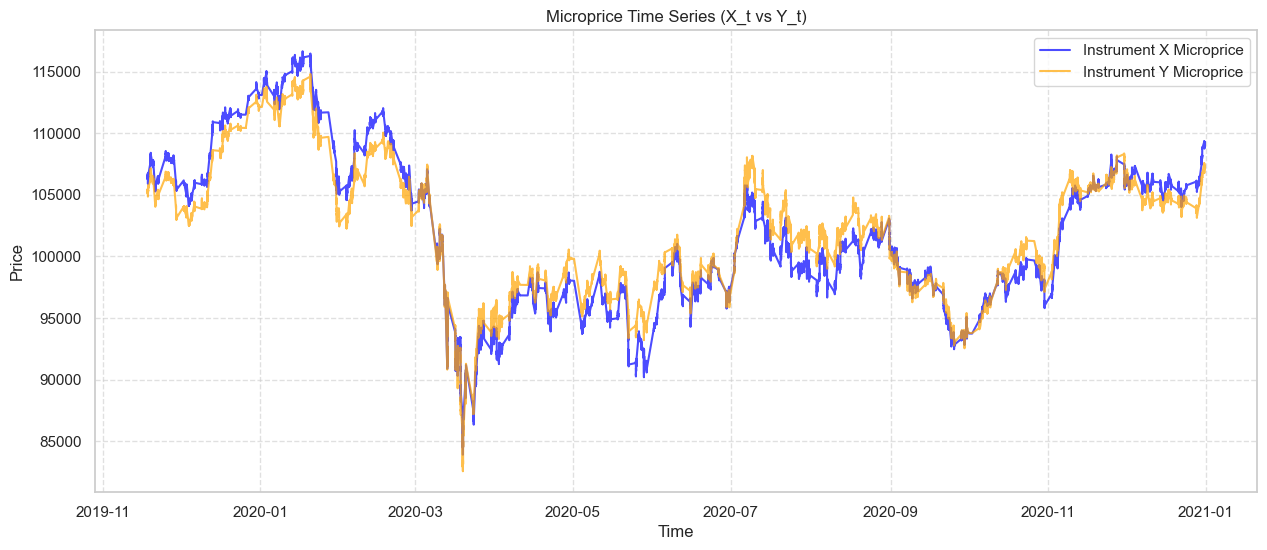

In [17]:
plt.figure(figsize=(15, 6))

# Plotting X_t
plt.plot(df['Time'], df['X_t'], label='Instrument X Microprice', color='blue', alpha=0.7)

# Plotting Y_t (Optional)
plt.plot(df['Time'], df['Y_t'], label='Instrument Y Microprice', color='orange', alpha=0.7)

plt.title('Microprice Time Series (X_t vs Y_t)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Looking at the above plot, we can see a clear anomaly around March-April 2020, which coincides with the COVID-19 volatility shock in early 2020. Such periods highlight the importance of monitoring volatility dynamics, particularly in high frequency settings where regime shifts can materially impact trading strategies

**Volatility and Handling of Overnight Gaps**

For high frequency data that can especially be affected by the effects of shocks such as the pandemic, it would be wise to perform rolling volatility to observe phases of regime shifts. To perform rolling volatility, we would have to calculate the log returns of $X_t$ and $Y_t$. Log returns specifically allow us to be time additive. To see what this means let us analyse the following:

$$r_t = \log (P_t) - \log(P_{t-1})$$

The log operation allows us to transform usual multiplicative dynamics (if we use the usual formula $r_t = \frac{P_t - P_{t-1}}{P_{t-1}}$) into additive state updates, and so we are able to measure proportional prices changes that are scale invariant.
$$\sum r_t = \log(P_T/P_0)$$

Another thing we must keep in mind as well is that our data is not fully continuous, from careful inspection of the market data, there is only continuous 10 second data between 8am - 10am and 11am - 2pm, so we must be cautious with how we construct rolling statistics. Overnight gaps represent discrete information jumps and would distort intraday volatility estimates if included within rolling windows. Hence, we must seperate intraday returns and overnight returns. This is especially important for when we consider rolling volatility. 

Additionally, weekends (non-trading periods) were removed from the dataset. Including weekends introduces artificial distortions, as prices remain static while time continues to advance, leading to misleading estimates of volatility, correlation, and spread dynamics. In earlier iterations of the analysis, retaining weekend observations significantly biased the intraday statistics and correlation structure. Removing these periods ensures that all calculations reflect active trading intervals only and preserves the integrity of the time-series properties.

When computing rolling statistics and differences, it is best to perform these in individual blocks of 8-10 am and 11 am - 2pm such to avoid the 1 hour gap to contaminate the statistics. This is implemented below.

In [18]:
vol_df = df.copy()


vol_df['mid_X'] = (df['X_BID'] + df['X_ASK']) / 2
vol_df['mid_Y'] = (df['Y_BID'] + df['Y_ASK']) / 2

#detect new day (avoid the overnight gap)
is_new_day = vol_df['Time'].dt.date != vol_df['Time'].shift(1).dt.date

#intraday gaps from 10am to 11am:
GAP = pd.Timedelta('5min')
is_gap = (vol_df['Time'].diff() > GAP).fillna(True)

#starting a new block:
is_new_block = is_new_day | is_gap
vol_df['block_id'] = is_new_block.cumsum()

vol_df['ret_X'] = vol_df.groupby('block_id')['log_X'].diff()
vol_df['ret_Y'] = vol_df.groupby('block_id')['log_Y'].diff()

vol_df['ret_X_mid'] = vol_df.groupby('block_id')['mid_X'].diff()
vol_df['ret_Y_mid'] = vol_df.groupby('block_id')['mid_Y'].diff()

#Note, since we are computing the log return which includes the operation of a diff,
# we must exclude difference over a day, i.e between 2 pm yesterday and 8 am today.

window = 6 * 60 #(1 hour window)
vol_df['date'] = vol_df['Time'].dt.date

vol_df['roll_vol_X'] = (vol_df.groupby('block_id')['ret_X']
                        .transform(lambda s: s.rolling(window, min_periods = window).std()))
#perform standard deviation calculation intraday to avoid incorrect inflation of volatility

vol_df['roll_vol_Y'] = (vol_df.groupby('block_id')['ret_Y']
                        .transform(lambda s: s.rolling(window, min_periods = window).std()))


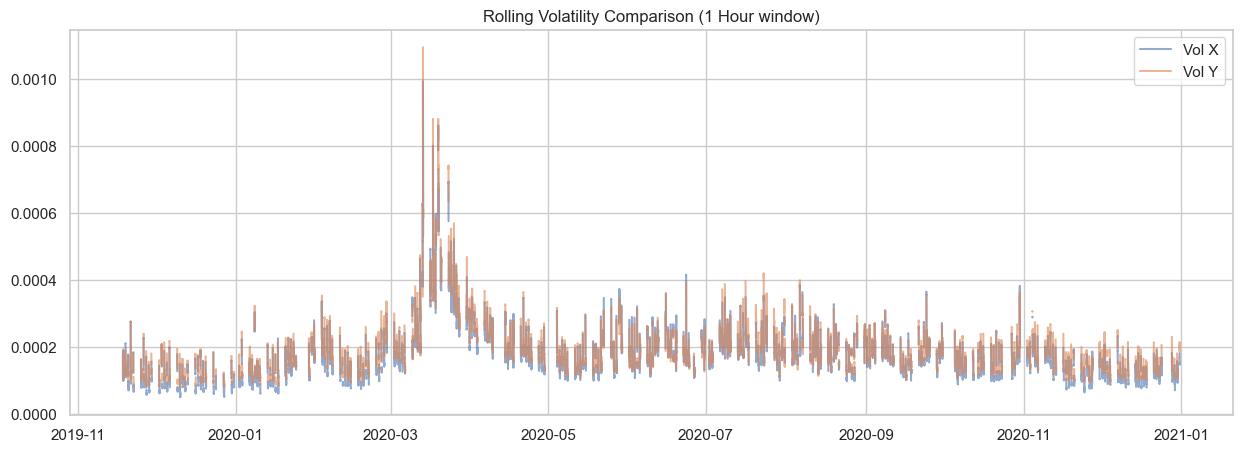

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(vol_df['Time'], vol_df['roll_vol_X'], label='Vol X', alpha=0.6)
plt.plot(vol_df['Time'], vol_df['roll_vol_Y'], label='Vol Y', alpha=0.6)
plt.title("Rolling Volatility Comparison (1 Hour window)")
plt.legend()
plt.show()

We observe here that the period of 2020-04 exhibits significantly elevated volatility, consistent with the COVID-19 market shock. Observation of these regime shifts are very important, as they may alter correlation structure, hedge ratios and liquidity conditions. It is therefore important to assess whether the relationship between X and Y remains stable accross voltility regimes and whether any trading signal is robust to these structural changes. So let us analyse correlation:

**Correlation**

We next examine the correlation between the two instruments. Since price levels are typically non-stationary and may share common trends, computing correlation on levels can lead to spurious results driven by shared drift rather than genuine co-movement.

To measure short-term comovement properly, we compute rolling correlation of log returns. Returns remove deterministic trends and capture proportional price changes, allowing us to assess whether the two instruments respond similarly to new information.

A persistently high rolling return correlation would suggest that the instruments are driven by common shocks, providing a foundation for further analysis of equilibrium relationships and potential relative value strategies.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


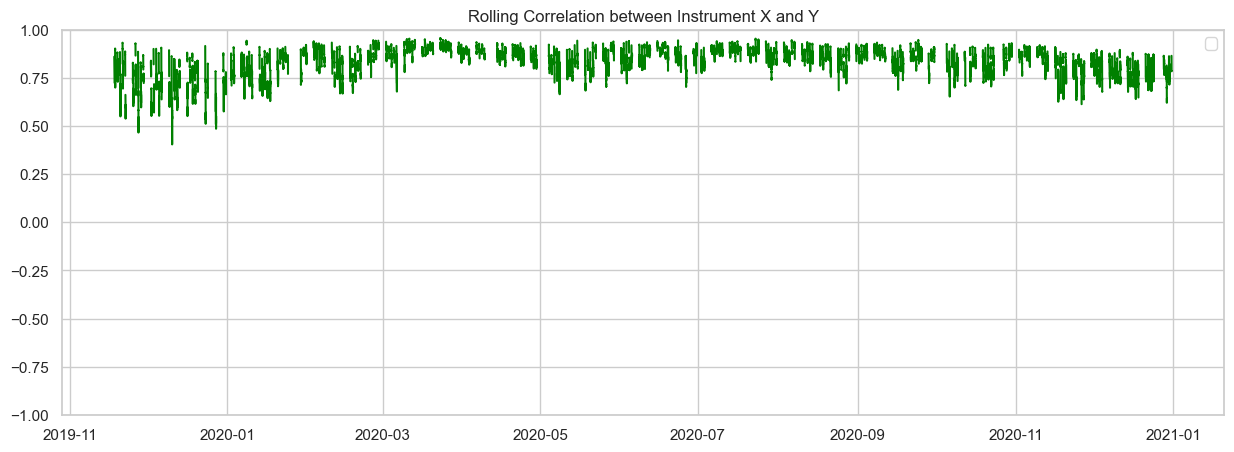

In [20]:
vol_df['roll_corr'] = (vol_df.groupby('block_id').apply(lambda g: g['ret_X'].rolling(window, min_periods = window).corr(g['ret_Y']))
.reset_index(level=0, drop = True)
                       )


plt.figure(figsize=(15, 5))
plt.plot(vol_df['Time'], vol_df['roll_corr'], color='green')
plt.title("Rolling Correlation between Instrument X and Y")
plt.ylim(-1, 1)
plt.legend()
plt.show()

An interesting observation here is that the during the high volatile period from the previous graph (2020-04) exhibits a relatively higher and consistent correlation. This possibly indicates a regime shift, which would make sense it is consistent with the COVID-19 shock.

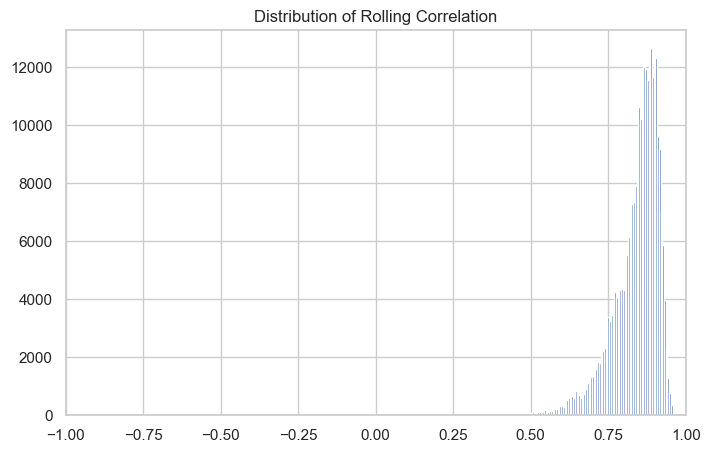

In [21]:
plt.figure(figsize=(8,5))
plt.hist(vol_df['roll_corr'].dropna(), bins=100)
plt.xlim(-1, 1)
plt.title("Distribution of Rolling Correlation")
plt.show()

The negative skewness of the above correlation poses an interesting observation as we have a large distribution of points possessing a high correlation coefficient, with a left tail of low coefficients. This further supports the idea of implementing a model that is conscious of the regime that it is currently in. From previous experience working in multi-target tracking, we could apply a hidden Markov model to deduce a hidden state (regime of the market) provided observations (i.e rolling volatility, correlation etc.). Definitely something interesting to further investigate in the future. 

In [22]:
vol_df['roll_corr'].describe()

count    295732.000000
mean          0.839680
std           0.073220
min           0.404610
25%           0.804633
50%           0.858049
75%           0.892327
max           0.957504
Name: roll_corr, dtype: float64

In [23]:
vol_df['roll_corr'].quantile([0.01, 0.05, 0.95, 0.99])

0.01    0.601799
0.05    0.694614
0.95    0.924008
0.99    0.939328
Name: roll_corr, dtype: float64

Note we have a rolling window size of 360, which corresponds to 1 hour. The reason why a rolling window of size of 360 was chosen was because this allows us to be able to see notable regions where the correlation between the returns changes significantly. Notice from the above plots, for the majority of the days, we observe a moderately strong positive correlation between the returns of the instruments, around 0.858. 


The rolling return correlation is persistently moderately high throughout the sample with 75% of observations above 0.805. This indicates some signal of a short-run comovement between X and Y.

The mean correlation (0.839) is slightly lower than the median due to variating correlation coefficient values near the beginning of the plot. 

Overall, the distribution suggests that the instruments are linked in the majority of trading periods.

**Cointegration**

While correlation confirms strong short-run comovement, it does not guarantee a stable long-run equilibrium in price levels. We therefore next examine whether a stationary linear combination between the price of the instruments exists. Particularly, in pairs trading, we rely on the spread between the prices of the 2 instruments X and Y to exhibit a property known as mean reversion. Formally, we write that the spread between the prices is stationary:
$$S_t = P_X - \beta P_Y = I(0)$$

So let us now perform a test for cointegration. To do this, we first construct a regression problem:
$$X_t = \alpha_1 + \beta_1 Y_t + \varepsilon_t$$
$$Y_t = \alpha_2 + \beta_2 X_t + \varepsilon_t$$
Note, we consider 2 regression problems due to the asymmetry of OLS. This point will be further elaborated below.


In [24]:
X = sm.add_constant(vol_df['Y_t'])
model = sm.OLS(vol_df['X_t'], X).fit()

beta_1 = model.params[1]
alpha_1 = model.params[0]

print(beta_1)
print(alpha_1)
print(model.summary())

1.1413814138722094
-14645.4994587371
                            OLS Regression Results                            
Dep. Variable:                    X_t   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                 1.053e+07
Date:                Mon, 16 Feb 2026   Prob (F-statistic):               0.00
Time:                        22:44:17   Log-Likelihood:            -4.2558e+06
No. Observations:              494671   AIC:                         8.512e+06
Df Residuals:                  494669   BIC:                         8.512e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.4

*The large condition number is driven by the scale of the price variables (on the order of 10^5) relative to the intercept column. Since this is a simple two-parameter regression with no multicollinearity, the warning reflects numerical scaling rather than identification issues. 

Notice there is a very strong correlation between the price levels of the 2 instruments, which is expected as noted before, this is likely a case of spurious correlation.

In [68]:
Y = sm.add_constant(vol_df['X_t'])
model2 = sm.OLS(vol_df['Y_t'], Y).fit()

beta_2 = model2.params[1]
alpha_2 = model2.params[0]

print("beta2 (Y on X):", beta_2)
print("alpha2:", alpha_2)
print(model2.summary())

beta2 (Y on X): 0.8368116981772427
alpha2: 16832.94350967191
                            OLS Regression Results                            
Dep. Variable:                    Y_t   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                 1.053e+07
Date:                Mon, 16 Feb 2026   Prob (F-statistic):               0.00
Time:                        23:14:40   Log-Likelihood:            -4.1790e+06
No. Observations:              494671   AIC:                         8.358e+06
Df Residuals:                  494669   BIC:                         8.358e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

Let us now look into the spread.

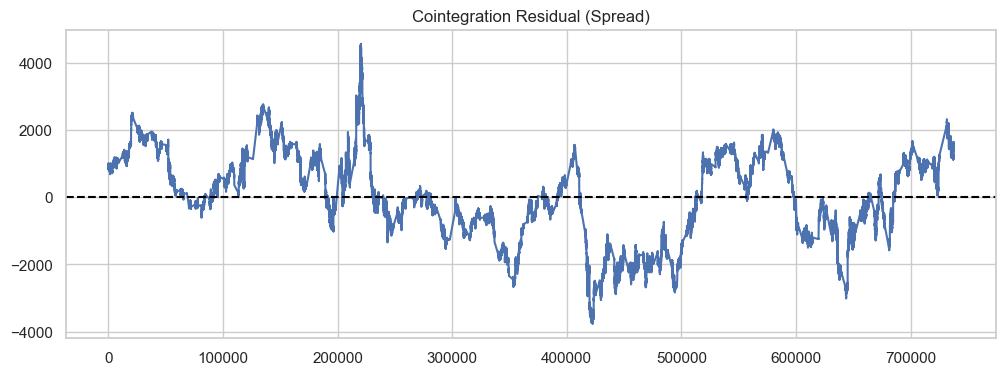

In [69]:
vol_df['spread_XonY'] = vol_df['X_t'] - (alpha_1 + beta_1 * vol_df['Y_t'])

plt.figure(figsize=(12,4))
plt.plot(vol_df['spread_XonY'])
plt.axhline(vol_df['spread_XonY'].mean(), color='black', linestyle='--')
plt.title("Cointegration Residual (Spread)")
plt.show()

**Stationarity as a preliminary step**

So how do we test that the spread above is stationary? To investigate this, lets show an example of analysing whether $X_t$ is stationary or not. We will first work with a simpler case, looking at an integrated process of order 1:
$$X_t = \mu + \phi X_{t-1} + \varepsilon_t$$
Additionally, we assume that $\varepsilon_t$ is a random variable with 0 mean and a constant finite variance. 
$$\forall t, \mathbb{E}(\varepsilon_t) = 0, \text{Var}(\varepsilon_t) = \sigma^2$$
Now we ask the question, what conditions make the above signal stationary? Lets recurse through the above equation, we can see that:
$$X_t = \mu + \phi^t X_0 + \sum_{k=0}^{t-1} \phi^k \epsilon_{t-k}$$
Notice:
$$\mathbb{E}(X_t) = \mu + \phi^t X_0 $$
$$\text{Var}(X_t) = \sigma^2 \sum_{k=0}^{t-1} \phi^{2k}$$
From the above, we can see that if $|\phi| < 1$:
$$\lim_{t \rightarrow \infty} \mathbb{E}(X_t) = \mu $$
$$\lim_{t \rightarrow \infty} \text{Var}(X_t) = \frac{\sigma^2}{1-\phi^2}$$
However, for $|\phi| = 1$:
$$\lim_{t \rightarrow \infty} \mathbb{E}(X_t) = \mu + X_0$$
$$\lim_{t \rightarrow \infty} \text{Var}(X_t) = \infty$$
The above case is known as the unit root, which leads to a non-stationary signal. The above 2 cases forms the argument for how the Dickey Fuller and ADF tests are formed. (Note, the case where $|\phi| > 1$ would lead to an exploding mean as $t \rightarrow \infty$ and is therefore non-stationary). Ultimately to test whether a signal is stationary, we adopt the null hypothesis that:
$$H_0: \phi = 1$$
And the alternate hypothesis:
$$H_1: |\phi| < 1$$
Let us now revist:
$$X_t = \mu + \phi X_{t-1} + \varepsilon_t$$
Consider:
$$X_t - X_{t-1} = \Delta X_t= \mu + (\phi - 1) X_{t-1} + \varepsilon_t$$
Under the null hypothesis that $\phi = 1$, we see that:
$$\Delta X_t= \mu + \varepsilon_t$$
Which means that $\Delta X_t$ is stationary. To test whether the signal is stationary, lets re-express, let $\delta = \phi -1$:
$$\Delta X_t= \mu + \delta X_{t-1} + \varepsilon_t$$
With the following hypotheses:
$$H_0: \delta = 0$$
$$H_1: \delta < 0$$
Hence, we can essentially perform OLS where the dependent variable is $\Delta X_t$ and the regressor is $X_{t-1}$. Once we perform the regression and retrieve the estimator $\hat{\delta}$, we perform a t-test:
$$t_\delta = \frac{\hat{\delta}}{SE(\hat{\delta})}$$
However, we do not compare this with the standard t- distribution as under the null hypothesis $X_{t-1}$ is non-stationary, so the limiting distribution of $\frac{\hat{delta}}{SE(\hat{\delta})}$ is actually the Dickey-Fuller distribution. Thus we would reject the null hypothesis when:
$$t_{\hat{\delta}} < DF_{critical}$$
The augmented Dickey-Fuller test is required for when we look at high order integrated processes:
$$X_t = \mu + \sum_{i=1}^P \phi_i X_{t-i} + \varepsilon_t $$
Let us rewrite this:
$$X_t - X_{t-1} = \Delta X_t = \mu + (\phi_1 - 1)X_{t-1} + \sum_{i=2}^P \phi_i X_{t-i} + \varepsilon_t $$
Now, let $\delta = \phi_1 -1 $ and $\beta_i$ be some real numbers s.t. $\sum_{i=1}^P \beta_i \Delta X_{t-i} = \sum_{i=2}^P \phi_i X_{t-i}$
$$ \Delta X_t = \mu + \delta X_{t-1} + \sum_{i=1}^P \beta_i \Delta X_{t-i} + \varepsilon_t  $$
And then we essentially perform the same idea as above. Note the value $P$ tells us the lag value, which is very important to consider later on

So, lets use the ADF test to observe that X and Y are non-stationary:

In [27]:
adf_X = adfuller(vol_df['X_t'], regression='c', maxlag=5, autolag='AIC')
adf_Y = adfuller(vol_df['Y_t'], regression='c', maxlag=5, autolag='AIC')

print("X ADF:", adf_X[0], "p:", adf_X[1])
print("Y ADF:", adf_Y[0], "p:", adf_Y[1])

X ADF: -1.8193342802152812 p: 0.37090588344201775
Y ADF: -2.2750760060230073 p: 0.18013248377219848


**Formulating a test for Cointegration via Stationarity and ADF**

Observing the above results, the p-value represents, under the null hypothesis of a unit root, the probability of obtaining a test statistic at least as extreme as the one observed. For both $X_t$ and $Y_t$, the p-values (0.371 and 0.180 respectively) are greater than conventional significance levels such as 5%. Therefore, we fail to reject the null hypothesis that the series contains a unit root. This indicates that the price series are non-stationary. So, now lets test cointegration between $X_t$ and $Y_t$. 

So, from the above derivations, the process to test whether $X_t$ and $Y_t$ are cointegrated is to look at the spread between the 2 instruments and then apply ADF to test whether it is stationary. Now, let us revisit as to why we had to perform OLS twice for the Spread of X on Y and the Spread of Y on X:
$$X_t = \alpha_1 + \beta_1 Y_t + \varepsilon_t$$
$$Y_t = \alpha_2 + \beta_2 X_t + \varepsilon_t$$
Recall that OLS is not symmetric and so the above spreads would yield different estimates of the cointegrating coefficient nd therefore different spread series. 

This asymmetry arises because ordinary least squares (OLS) minimizes the sum of squared errors in the dependent variable only. When we regress  
$$X_t = \alpha_1 + \beta_1 Y_t + \varepsilon_t$$

we are minimizing deviations in $X_t$. When we reverse the regression, we instead minimize deviations in $Y_t$.

Since cointegration concerns the existence of any stationary linear combination of the two non-stationary series, the choice of dependent variable can influence the estimated spread and its stationarity properties.

Therefore, we will estimate the regression in both directions and apply the Augmented Dickey–Fuller (ADF) test to each resulting residual series. The specification that provides stronger evidence of stationarity—indicated by a more negative ADF test statistic (or equivalently, a smaller p-value)—is selected as the preferred cointegrating relationship. The corresponding coefficient is then used to define the spread.

**Autocorrelation Analysis for identification of Integrated process order (ADF Testing)**

So lets revisit the construction:
$$ \Delta X_t = \mu + \delta X_{t-1} + \sum_{i=1}^P \beta_i \Delta X_{t-i} + \varepsilon_t  $$

We must now determine an appropriate value for $P$ so that the ADF regression properly captures the short-run dynamics of the spread while preserving valid statistical inference. The parameter $P$ denotes the number of lagged differences $\Delta X_{t-i}$ included in the regression to account for potential serial correlation in the error term. Including these lags ensures that the residuals of the ADF regression behave approximately as white noise, satisfying our assumption that:
$$\mathbb{E}(\varepsilon_t) = 0, \text{Var}(\varepsilon_t) = \sigma^2$$

To inform this choice, we examine the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the first-differenced spread. The ACF measures the correlation between a series and its past values at different lags, providing insight into the persistence of shocks over time. The PACF, on the other hand, measures the direct correlation between the series and a particular lag after controlling for the influence of intermediate lags. While the ACF reflects overall dependence across time, the PACF helps identify the effective order of autoregressive structure.

If the ACF decays quickly and becomes negligible after only a few lags, this indicates short memory in the process and suggests that a small value of $P$ is sufficient. Conversely, a slow decay would imply more persistent dynamics and the need for additional lag terms.



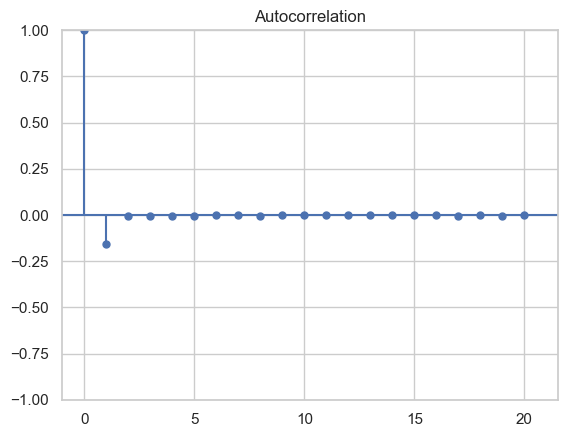

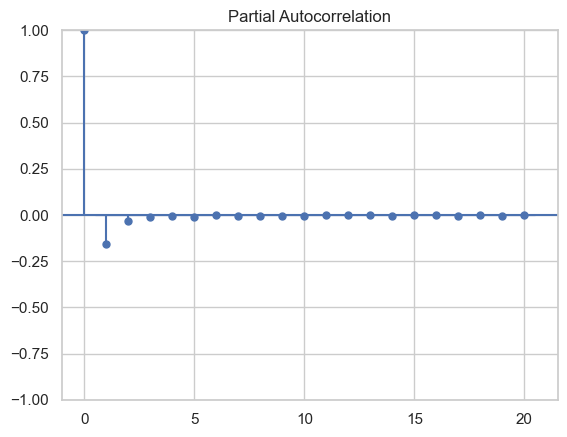

In [ ]:
ds = vol_df['spread_XonY'].diff().dropna()

plot_acf(ds, lags=20)
plt.show()

plot_pacf(ds, lags=20, method="ywm")
plt.show()

The autocorrelation (ACF) and partial autocorrelation (PACF) plots of the first-differenced spread indicate very limited serial dependence. Apart from the trivial spike at lag 0, the autocorrelations at subsequent lags are small in magnitude and decay rapidly toward zero. There is no evidence of a slow, persistent decay pattern that would suggest long memory in the process. Similarly, the PACF does not display any significant spikes beyond the first few lags, indicating the absence of a higher-order autoregressive structure.

This rapid decay implies that the short-run dynamics of the differenced spread are captured within only a few lags. Consequently, setting the maximum lag length to $P = 5$ in the ADF regression is sufficient to account for any minor residual autocorrelation while avoiding overfitting. Allowing up to five lagged differences provides a conservative upper bound that ensures the regression errors approximate white noise without unnecessarily increasing model complexity.

In [29]:
adf = adfuller(vol_df['spread_XonY'].values, regression="n", autolag="AIC", maxlag=5)

print("ADF stat:", adf[0])
print("p-value:", adf[1])
print("used lag:", adf[2])
print("nobs:", adf[3])
print("crit vals:", adf[4])

ADF stat: -3.0565924173881416
p-value: 0.002217450994473444
used lag: 5
nobs: 494665
crit vals: {'1%': -2.5657445198413718, '5%': -1.941000543007495, '10%': -1.6168194630820583}


In [30]:
vol_df['spread_YonX'] = vol_df['Y_t'] - (alpha_2 + beta_2 * vol_df['X_t'])

adf = adfuller(vol_df['spread_YonX'].values, regression="n", autolag="AIC", maxlag=10)

print("ADF stat:", adf[0])
print("p-value:", adf[1])
print("used lag:", adf[2])
print("nobs:", adf[3])
print("crit vals:", adf[4])

ADF stat: -3.2979758140563176
p-value: 0.000986100152447487
used lag: 10
nobs: 494660
crit vals: {'1%': -2.5657445198870583, '5%': -1.9410005430129837, '10%': -1.6168194630766313}


When comparing the two residual-based ADF tests, the spread obtained from regressing $Y_t$ on $X_t$ produces a more negative test statistic and a smaller p-value. We therefore adopt this specification, as it provides stronger evidence of residual stationarity. However, it is important to distinguish this comparison from the formal `coint()` implementation, which applies MacKinnon-adjusted critical values that account for the generated-regressor nature of the residual. While the residual ADF comparison guides our choice of hedge ratio ($\beta$), the formal cointegration inference should be based on the Engle–Granger test statistic. 


Accordingly, we define the spread as:

$$
S_t = Y_t - (\alpha_2 + \beta_2 X_t)
$$

Using the estimated coefficients:

$$
\beta_2 = 0.839, \qquad
\alpha_2 = 16590.83
$$

so that

$$
S_t = Y_t - (16590.83 + 0.839 X_t).
$$


In [31]:
coint_t, pvalue, crit_vals = coint(
    vol_df['X_t'],
    vol_df['Y_t'],
    trend='c',
    maxlag=5,
    autolag= 'AIC'
)

print("Cointegration test statistic:", coint_t)
print("p-value:", pvalue)
print("critical values:", crit_vals)

Cointegration test statistic: -3.0565924173882024
p-value: 0.09735823608705146
critical values: [-3.89646214 -3.33614235 -3.04445857]


The Engle–Granger cointegration test yields a test statistic of -3.057 with a corresponding p-value of 0.0974. Comparing this value to the MacKinnon-adjusted critical values, we observe that the statistic does not exceed the 5% critical threshold (-3.336), but it barely exceeds the 10% critical value (-3.044). Therefore, we fail to reject the null hypothesis of no cointegration at the 5% significance level, but reject it at the 10% level. 

This indicates weak evidence of a long-run equilibrium relationship between the two instruments. While the residual-based ADF tests suggested strong stationarity using standard Dickey–Fuller critical values, the formally adjusted Engle–Granger test provides a more conservative assessment. Consequently, the evidence for cointegration is present but not overwhelmingly strong, and any pairs trading strategy based on this relationship should be evaluated carefully. 

**Periodic Patterns**

To formulate a concrete trading strategy, let us observe some periodic patterns:

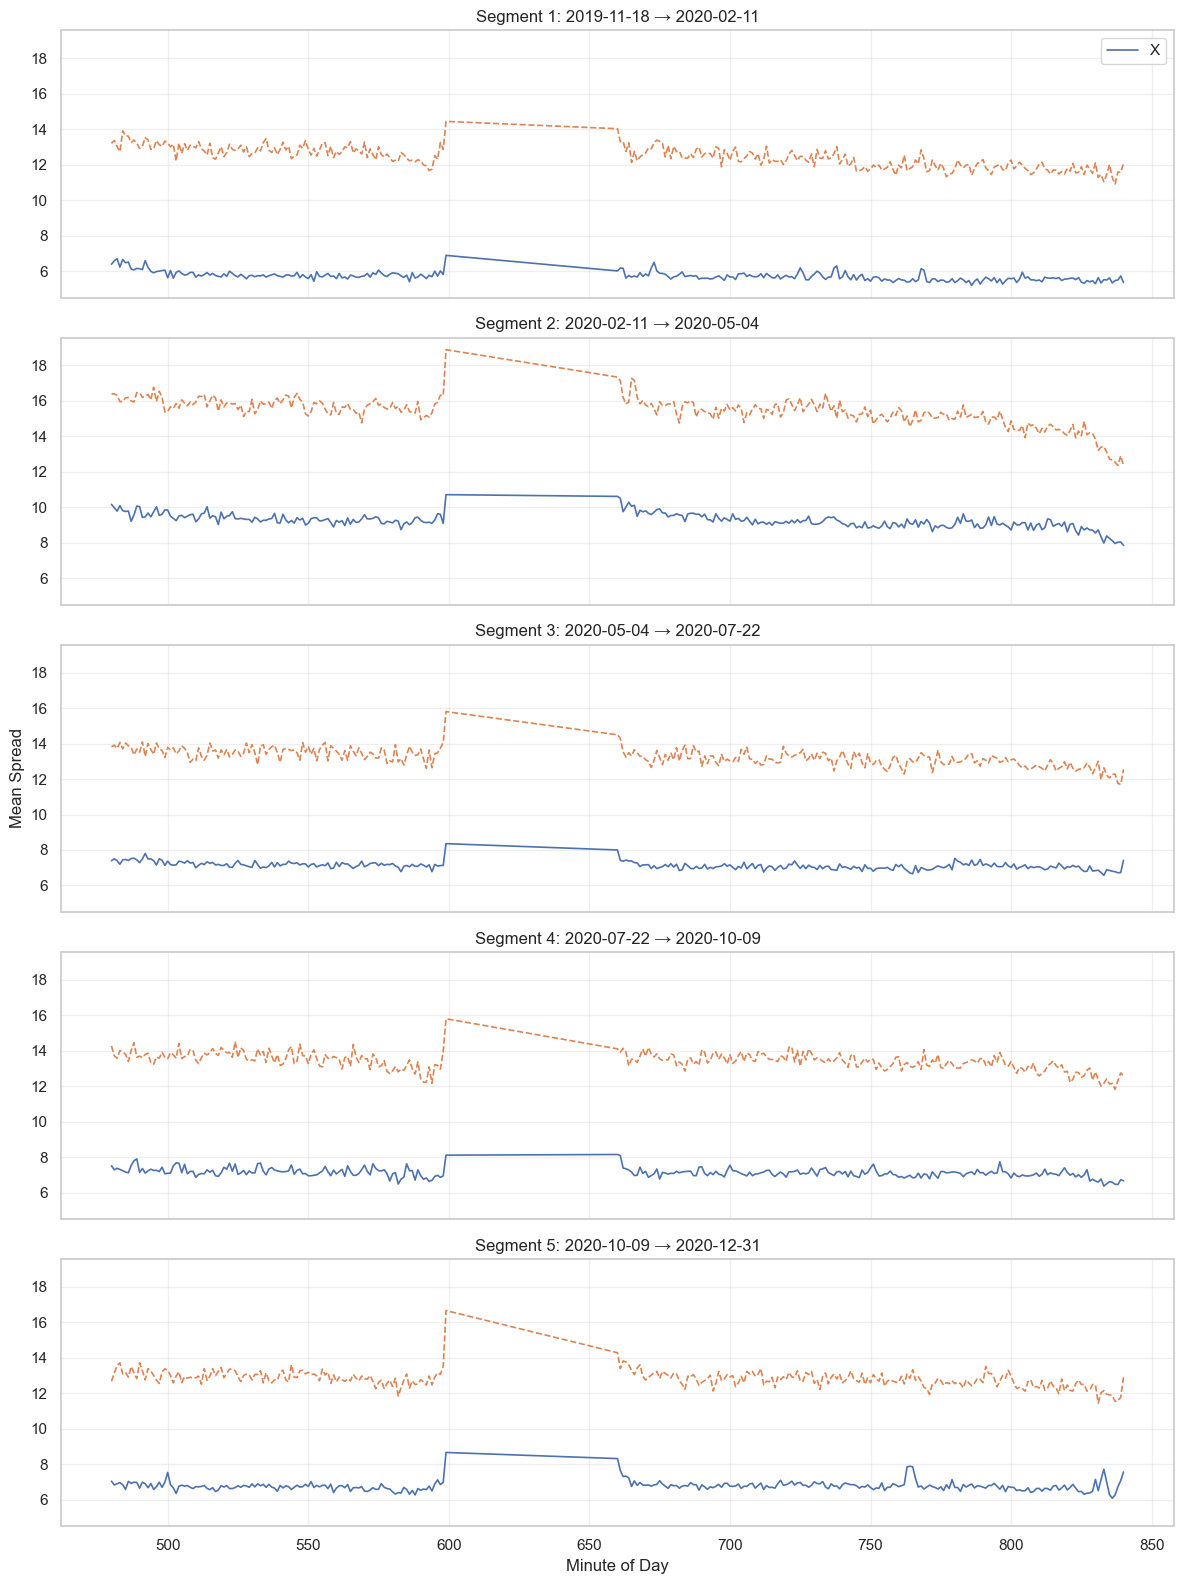

In [93]:
vol_df['hour'] = vol_df['Time'].dt.hour
vol_df['minute_of_day'] = 60 * vol_df['hour'] +  vol_df['Time'].dt.minute




# Create segment labels 0–4 (chronological fifths)
vol_df["segment"] = pd.qcut(vol_df.index, 5, labels=False)

fig, axes = plt.subplots(5, 1, figsize=(12, 16), sharex=True, sharey=True)

for seg in range(5):
    seg_data = vol_df[vol_df["segment"] == seg]

    spread_X = seg_data.groupby("minute_of_day")["X_spread"].mean()
    spread_Y = seg_data.groupby("minute_of_day")["Y_spread"].mean()

    # Optional smoothing
    # spread_X = spread_X.rolling(5, min_periods=1).mean()
    # spread_Y = spread_Y.rolling(5, min_periods=1).mean()

    start_date = seg_data["Time"].min().date()
    end_date = seg_data["Time"].max().date()

    axes[seg].plot(spread_X.index, spread_X.values, label="X", linewidth=1.2)
    axes[seg].plot(spread_Y.index, spread_Y.values, linestyle="--", linewidth=1.2)

    axes[seg].set_title(f"Segment {seg+1}: {start_date} → {end_date}")
    axes[seg].grid(alpha=0.3)

axes[0].legend()
axes[-1].set_xlabel("Minute of Day")
axes[2].set_ylabel("Mean Spread")

plt.tight_layout()
plt.show()

The dataset was split into five equal time segments to evaluate whether the intraday spread structure remains stable across different correlation regimes. Since rolling correlation fluctuates over time, segmenting the sample prevents full-period averages from masking regime-dependent behavior and allows us to test robustness of the relationship across time.

From the segmented analysis, Segment 2 clearly exhibits a higher average bid–ask spread compared to all other segments. This aligns with the earlier observation that this period corresponds to elevated market volatility. The wider spreads during this interval are consistent with standard microstructure theory: during high-volatility regimes, market makers increase spreads to compensate for greater inventory and adverse selection risk.

In addition, across all segments — and most notably for instrument Y — there is a pronounced and rapid widening of the spread immediately prior to the scheduled market break between 10:00 and 11:00 AM. This sharp expansion suggests a temporary withdrawal of liquidity as participants reduce exposure ahead of the trading halt, leading to thinner order books and higher quoted spreads.

Let us now look for any periodic behaviour in the residual spread of Y on X

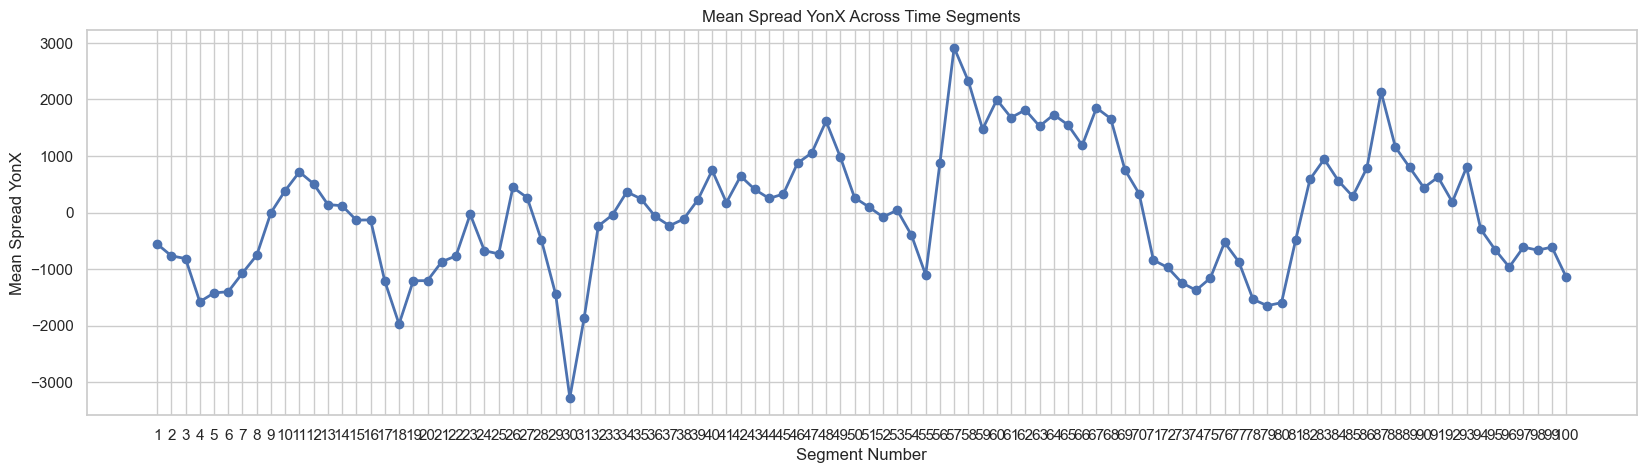

In [92]:
n = len(vol_df)
n_segments = 100
segment_size = n // n_segments

segment_means = []
segment_labels = []

for i in range(n_segments):
    start_idx = i * segment_size
    end_idx = (i + 1) * segment_size if i < n_segments - 1 else n
    
    segment = vol_df.iloc[start_idx:end_idx]
    
    mean_spread = segment['spread_YonX'].mean()
    segment_means.append(mean_spread)
    
    # Optional: label with date range
    start_date = segment['Time'].iloc[0].date()
    end_date = segment['Time'].iloc[-1].date()
    segment_labels.append(f"{start_date} → {end_date}")

# Plot
plt.figure(figsize=(20, 5))
plt.plot(range(1, n_segments + 1), segment_means, marker='o', linewidth=2)

plt.title("Mean Spread YonX Across Time Segments")
plt.xlabel("Segment Number")
plt.ylabel("Mean Spread YonX")
plt.xticks(range(1, n_segments + 1))
plt.grid(True)
plt.show()


By partitioning the sample into 100 chronological segments and examining the mean spread within each segment, we observe persistent regime-level shifts in the average spread. The spread does not fluctuate around a stable global mean; instead, it exhibits extended periods where the mean remains consistently positive or negative.

This suggests that the residual spread may contain slow-moving drift components or structural breaks. Consequently, a naïve mean-reversion strategy that assumes a stationary spread centered around a constant mean may be mis-specified, potentially resulting in prolonged holding periods and exposure to regime risk.

This motivates the idea of a rolling z-score strategy where we perform online updates to the beta value and other parameters of the residual spread such to adapt to these regimes. 

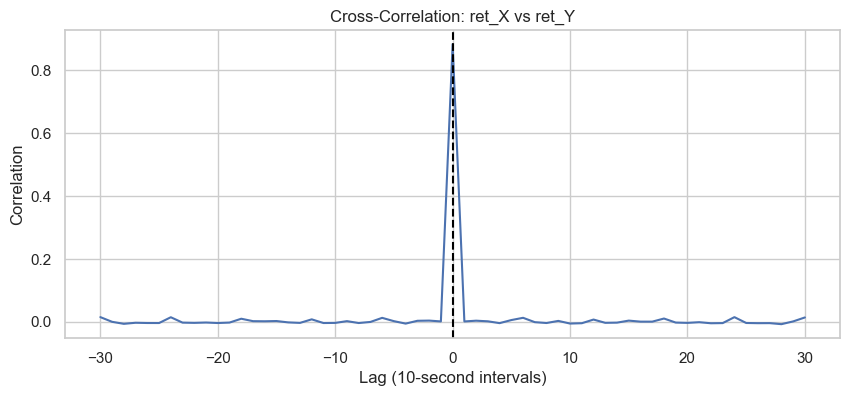

In [39]:
max_lag = 30  # 30 * 10s = 5 minutes
lags = range(-max_lag, max_lag+1)

cross_corr = []

for lag in lags:
    corr = vol_df['ret_X'].corr(vol_df['ret_Y'].shift(lag))
    cross_corr.append(corr)

plt.figure(figsize=(10,4))
plt.plot(lags, cross_corr)
plt.axvline(0, color='black', linestyle='--')
plt.title("Cross-Correlation: ret_X vs ret_Y")
plt.xlabel("Lag (10-second intervals)")
plt.ylabel("Correlation")
plt.show()

The cross-correlation function between $ r_X $ and $ r_Y $ shows a pronounced spike at lag 0, indicating strong contemporaneous correlation between the two return series. 

However, correlations at all non-zero lags are close to zero and do not exhibit any systematic structure. This implies there is no statistically meaningful lead–lag relationship between the instruments at the 10-second sampling frequency.

In other words, neither $ X $ leads $ Y $, nor $ Y $ leads $ X $. Price adjustments appear to occur simultaneously rather than sequentially, suggesting that any information is incorporated into both instruments contemporaneously.


## Rolling Strategy

A rolling window of **10 trading days** is used to estimate the time-varying hedge ratio $(\alpha_t, \beta_t) $ via rolling OLS.

This choice reflects the **bias–variance tradeoff** inherent in dynamic parameter estimation:

- **Shorter windows**
  - Lower bias (more adaptive to structural shifts)
  - Higher variance (estimates become noisy and unstable)

- **Longer windows**
  - Lower variance (more stable parameter estimates)
  - Higher bias (slower adaptation to changing market regimes)

A 10-day window provides a balanced compromise:  
it is long enough to reduce estimation noise from microstructure effects, yet short enough to allow the hedge ratio to adjust to medium-term changes in the relationship between X and Y.

In [94]:
from statsmodels.regression.rolling import RollingOLS

rolling_window = 10 * 24 * 360 #10 days

roll_df = vol_df.copy()

X = sm.add_constant(roll_df['X_t'])
y = roll_df['Y_t']

rolling_model = RollingOLS(y, X, window=rolling_window)
rolling_res = rolling_model.fit()

rolling_params = rolling_res.params
roll_df['alpha_t'] = rolling_res.params['const']
roll_df['beta_t'] = rolling_res.params['X_t']

# Calculate spread
roll_df['S_t'] = roll_df['Y_t'] - (roll_df['alpha_t'] + roll_df['beta_t'] * roll_df['X_t'])
print(rolling_params)

               const       X_t
0                NaN       NaN
1                NaN       NaN
2                NaN       NaN
3                NaN       NaN
4                NaN       NaN
...              ...       ...
494389  28030.261981  0.731274
494390  28030.454048  0.731272
494391  28030.665948  0.731270
494392  28030.847517  0.731268
494393  28031.007745  0.731267

[494394 rows x 2 columns]


In [95]:
spread = roll_df['Y_t'] - (rolling_params['const'] + rolling_params['X_t'] * roll_df['X_t'])

In [96]:
rolling_mean = spread.rolling(rolling_window).mean()
rolling_std = spread.rolling(rolling_window).std()
z_score = (spread - rolling_mean) / rolling_std
roll_df['z_t'] = z_score
print(z_score)

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
494389   -0.204906
494390   -0.191014
494391   -0.219363
494392   -0.170374
494393   -0.146052
Length: 494394, dtype: float64


In [97]:
dfp = pd.DataFrame({
        "ds_next": spread.diff().shift(-1),
        "z": z_score
    }).dropna()

X = sm.add_constant(dfp["z"])
y = dfp["ds_next"]
fit = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 30})
b = float(fit.params["z"])
t = float(fit.tvalues["z"])
r2 = float(fit.rsquared)

print(
    f"b: {b:.6f} | "
    f"t_hac: {t:.2f} | "
    f"R²: {r2:.6f} | "
    f"N: {int(fit.nobs):,}"
)


b: -0.059418 | t_hac: -3.45 | R²: 0.000027 | N: 321,595


In [98]:
spread_data = pd.DataFrame({'spread': spread,
                            'rolling mean' : rolling_mean,
                            'rolling std' : rolling_std,
                            'z score' : z_score},
                           index = roll_df.index)

print(spread_data)

            spread  rolling mean  rolling std   z score
0              NaN           NaN          NaN       NaN
1              NaN           NaN          NaN       NaN
2              NaN           NaN          NaN       NaN
3              NaN           NaN          NaN       NaN
4              NaN           NaN          NaN       NaN
...            ...           ...          ...       ...
494389 -662.602233   -470.904530   935.540783 -0.204906
494390 -649.623479   -470.924582   935.526046 -0.191014
494391 -676.161737   -470.944916   935.511415 -0.219363
494392 -630.348972   -470.964718   935.496681 -0.170374
494393 -607.612943   -470.984311   935.481814 -0.146052

[494394 rows x 4 columns]


<Figure size 2000x1000 with 0 Axes>

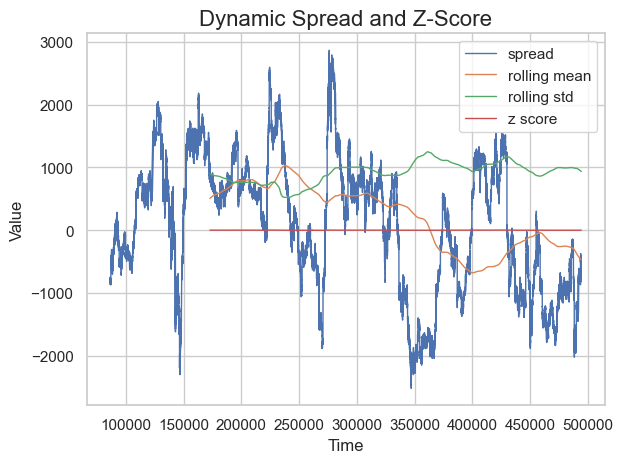

In [99]:
plt.figure(figsize=(20, 10))
spread_data.plot(linewidth=1)
plt.title("Dynamic Spread and Z-Score", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

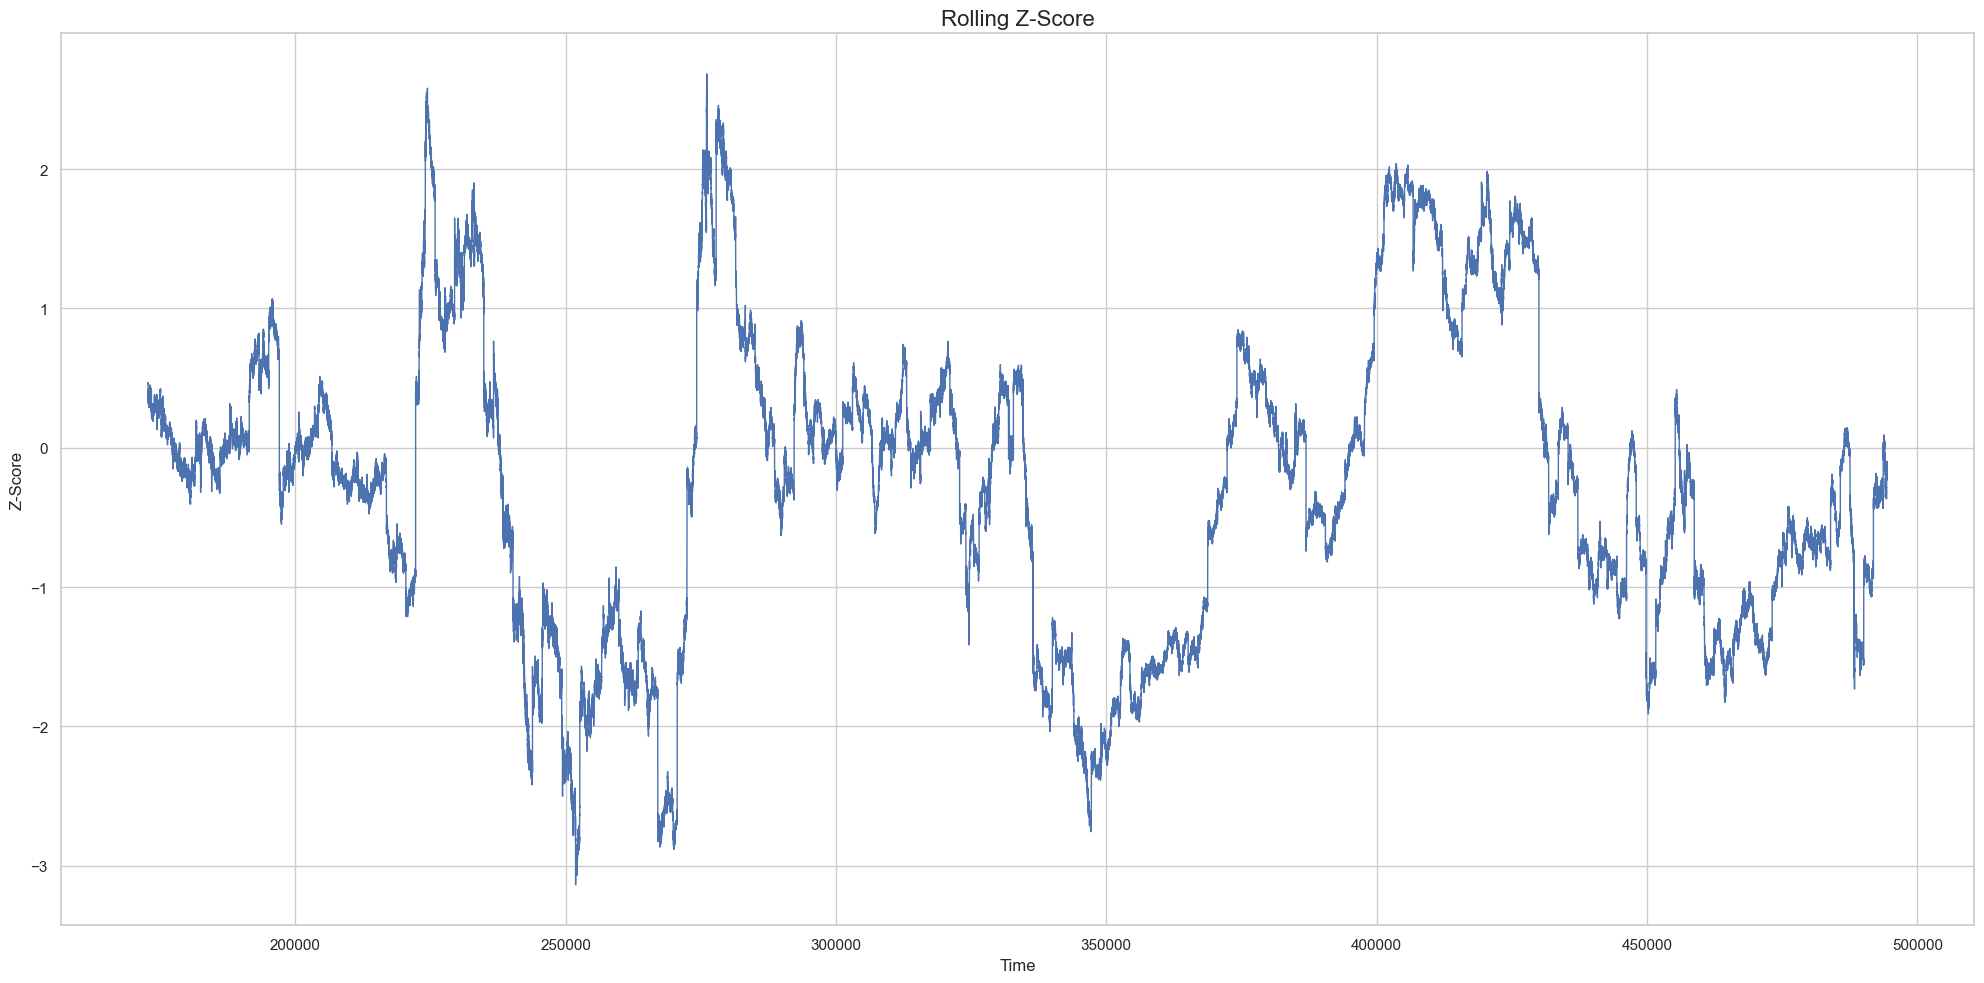

In [100]:
plt.figure(figsize=(20, 10))

spread_data['z score'].plot(linewidth=1)

plt.title("Rolling Z-Score", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Z-Score", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Notice, with the above graph, we encounter the same dilemma as before: the rolling $z$-score does not spend a significant amount of time beyond our entry thresholds (e.g. $\pm 1.5$ or $\pm 2$). While the series does exhibit mean-reverting behaviour, much of the movement appears choppy and noisy, with frequent small oscillations around zero rather than sustained dislocations.

$$S_t = Y_t - (\alpha_t + \beta_t X_t) $$
$$z_t = \frac{S_t - \mu_t}{\sigma_t}$$

The key strategy here is if $z_t > z_{enter}$ we perform a short spread where we short $Y$ and long $\beta X$, while if $z_t < -z_{enter}$, we perform a long spread where we long $Y$ and short $\beta X$. We would then exit when $|z_t| < z_{exit}$. The reason why we are look at the standard normal statistic $z_t$ is because it allows us to naturally perform a hypothesis test to evaluate whether the spread is likely to revert back assuming mean reversion as the null hypothesis. 


Before constructing trading signals, it is important to reduce microstructure noise in the raw price series. High-frequency price updates contain bid–ask bounce, order flow imbalance effects, and transient liquidity shocks, all of which can inflate short-term variance in the spread and obscure genuine mean-reverting dislocations.

To attenuate these high-frequency components, we apply an exponential moving average (EMA) to the price process.

The EMA is defined recursively as:

$$m_t = ax_t + (1-a) m_{t-1}$$

Via recursion, we can expand:

$$m_t = \sum_{k=0}^t \alpha(1-\alpha)^k x_{t-k}$$

Here, $0 \leq \alpha \leq 1$ controls the smoothing intensity. A larger $\alpha$ places greater weight on the most recent observation $x_t$, resulting in faster adaptation but less smoothing. A smaller $\alpha$ produces a smoother estimate with slower responsiveness.

However, our dataset contains intraday gaps and periods of market inactivity (e.g., weekends and holidays), which we have removed. As a result, observations are not uniformly spaced in time.

The standard EMA implicitly assumes equal time spacing between observations. When timestamps are irregular, using a fixed $\alpha$ incorrectly treats a 10-second gap the same as a multi-hour gap.

To address this, we adopt a time-decay EMA, where the smoothing weight depends explicitly on the elapsed time $\Delta t$ between observations:

$$ m_t = e^{-\lambda \Delta t} x_t + (1- e^{-\lambda \Delta t} )m_{t-1} $$

In [53]:
def time_decay_ema(prices, times, halflife_seconds):
    """
    Exponential moving average with time-based decay
    
    Parameters:
    -----------
    prices : array-like
        Price series
    times : array-like (datetime)
        Timestamps for each observation
    halflife_seconds : float
        Time (in seconds) for weight to decay by 50%
    
    Returns:
    --------
    ema : array
        Time-decay adjusted EMA
    """
    prices = np.array(prices)
    times = pd.to_datetime(times)
    
    ema = np.zeros(len(prices))
    ema[0] = prices[0]
    
    for i in range(1, len(prices)):
        # Calculate time gap in seconds
        dt = (times[i] - times[i-1]).total_seconds()
        
        # Time-decay factor: alpha = e^(-λ * dt)
        # where λ = ln(2) / halflife
        lambda_decay = np.log(2) / halflife_seconds
        alpha = np.exp(-lambda_decay * dt)
        
        # EMA update: m_t = e^(-λΔt) * m_{t-1} + (1 - e^(-λΔt}) * x_t
        ema[i] = alpha * ema[i-1] + (1 - alpha) * prices[i]
    
    return ema

In [103]:
# Split: 60% train, 40% test
split_idx = int(len(df) * 0.6)

train_df = df.copy()

test_df = df.iloc[split_idx:].copy()

In [104]:
print(len(train_df))
train_df

494671


,Time,X_BID,X_BID_VOL,X_ASK,X_ASK_VOL,Y_BID,Y_BID_VOL,Y_ASK,Y_ASK_VOL,run_id,...,X_t,X_spread,Y_t,Y_spread,OBI_X,OBI_Y,log_X,log_Y,mid_X,ret_X
0,2019-11-18 08:00:00,106340.0,15.0,106348.0,11.0,105200.0,9.0,105210.0,19.0,1,...,106343.384615,8.0,105206.785714,10.0,0.153846,-0.357143,11.574429,11.563683,106344.0,NaN
1,2019-11-18 08:00:10,106312.0,6.0,106320.0,9.0,105180.0,5.0,105190.0,13.0,2,...,106316.800000,8.0,105187.222222,10.0,-0.200000,-0.444444,11.574179,11.563497,106316.0,-0.000263
2,2019-11-18 08:00:20,106312.0,7.0,106320.0,12.0,105170.0,32.0,105180.0,1.0,3,...,106317.052632,8.0,105170.303030,10.0,-0.263158,0.939394,11.574181,11.563336,106316.0,0.000000
3,2019-11-18 08:00:30,106336.0,22.0,106340.0,1.0,105190.0,10.0,105200.0,19.0,4,...,106336.173913,4.0,105196.551724,10.0,0.913043,-0.310345,11.574361,11.563586,106338.0,0.000207
4,2019-11-18 08:00:40,106352.0,2.0,106356.0,4.0,105200.0,29.0,105220.0,24.0,5,...,106354.666667,4.0,105209.056604,20.0,-0.333333,0.094340,11.574535,11.563705,106354.0,0.000150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737734,2020-12-31 09:59:20,109140.0,2.0,109144.0,1.0,107190.0,6.0,107210.0,1.0,494507,...,109141.333333,4.0,107192.857143,20.0,0.333333,0.714286,11.600399,11.582385,109142.0,-0.000440
737735,2020-12-31 09:59:30,109144.0,1.0,109168.0,21.0,107170.0,1.0,107200.0,1.0,494508,...,109166.909091,24.0,107185.000000,30.0,-0.909091,0.000000,11.600633,11.582312,109156.0,0.000128
737736,2020-12-31 09:59:40,109120.0,4.0,109144.0,1.0,107170.0,3.0,107230.0,3.0,494509,...,109124.800000,24.0,107200.000000,60.0,0.600000,0.000000,11.600247,11.582452,109132.0,-0.000220
737737,2020-12-31 09:59:50,109092.0,2.0,109104.0,5.0,107180.0,3.0,107220.0,5.0,494510,...,109100.571429,12.0,107205.000000,40.0,-0.428571,-0.250000,11.600025,11.582498,109098.0,-0.000312


In [105]:
halflife_price = 50      # EMA span for price smoothing (~5 minutes)
halflife_spread = 3600    # EMA span for spread mean/std (~1 hour)
z_entry = 1.5
z_exit = 0.5

train_df['X_ema'] = time_decay_ema(
    train_df['X_t'].values,
    train_df['Time'].values,
    halflife_price
)

train_df['Y_ema'] = time_decay_ema(
    train_df['Y_t'].values,
    train_df['Time'].values,
    halflife_price
)


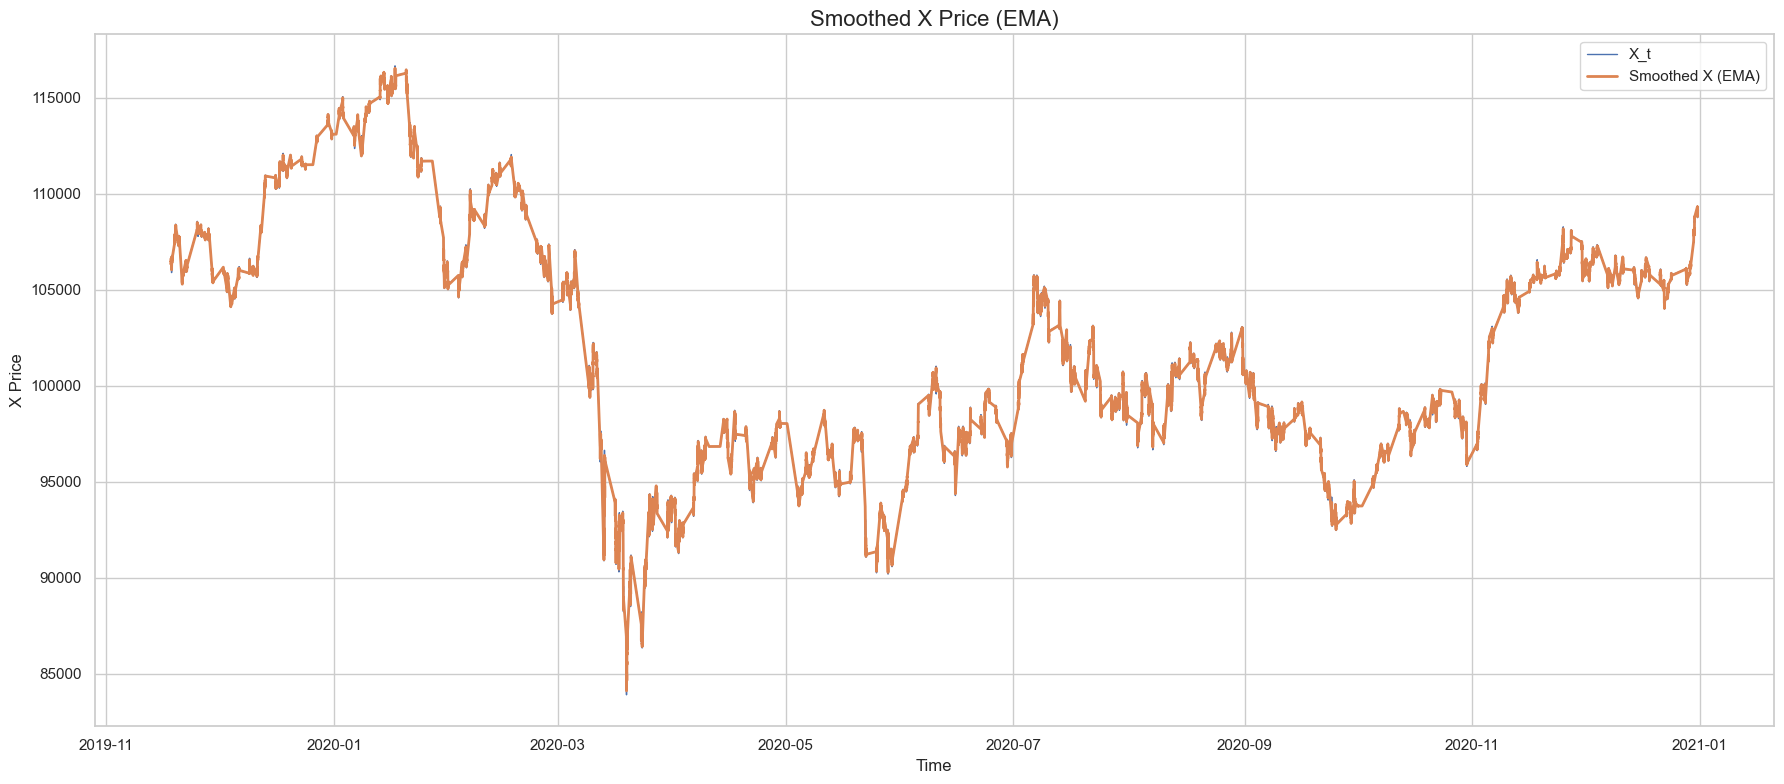

In [106]:
plt.figure(figsize=(18, 8))
plt.plot(train_df["Time"], train_df['X_t'], label='X_t', linewidth=1)
plt.plot(train_df['Time'], train_df['X_ema'], label=f'Smoothed X (EMA)', linewidth=2)


plt.title("Smoothed X Price (EMA)", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("X Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

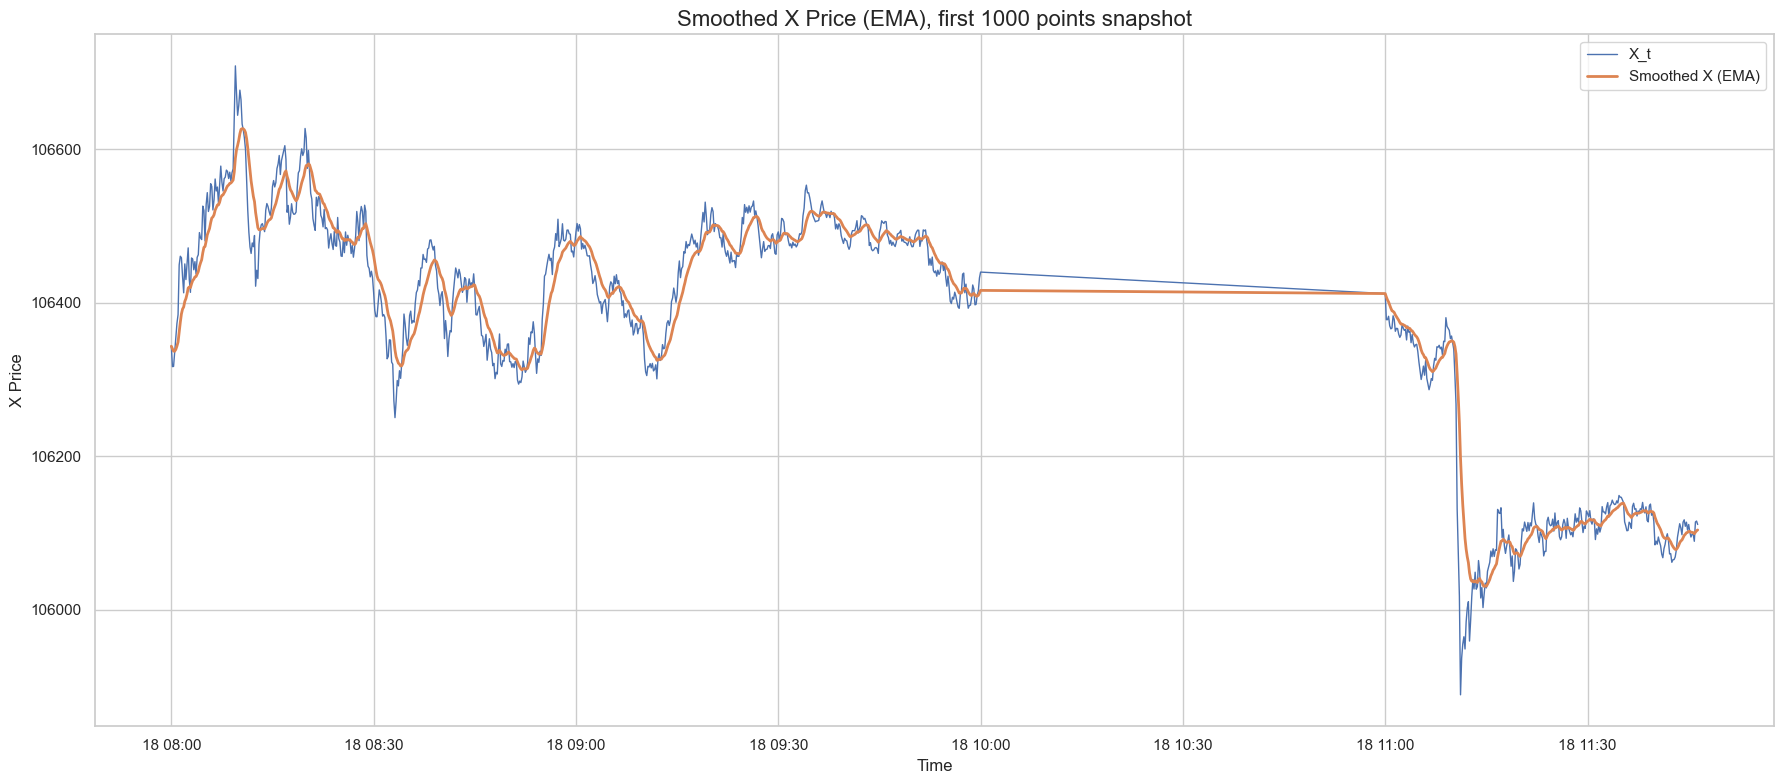

In [107]:
plt.figure(figsize=(18, 8))
plt.plot(train_df["Time"].iloc[:1000], train_df['X_t'].iloc[:1000], label='X_t', linewidth=1)
plt.plot(train_df['Time'].iloc[:1000], train_df['X_ema'].iloc[:1000], label=f'Smoothed X (EMA)', linewidth=2)


plt.title("Smoothed X Price (EMA), first 1000 points snapshot", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("X Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [145]:
X = sm.add_constant(train_df['X_ema'])
y = train_df['Y_ema']

# Fit rolling OLS
rolling_window = 703  # sqrt of 494671 data points (rule of thumb)
rolling_model = RollingOLS(y, X, window=rolling_window)
rolling_res = rolling_model.fit()

# Extract parameters
train_df['beta_ols'] = rolling_res.params['X_ema']
train_df['alpha_ols'] = rolling_res.params['const']



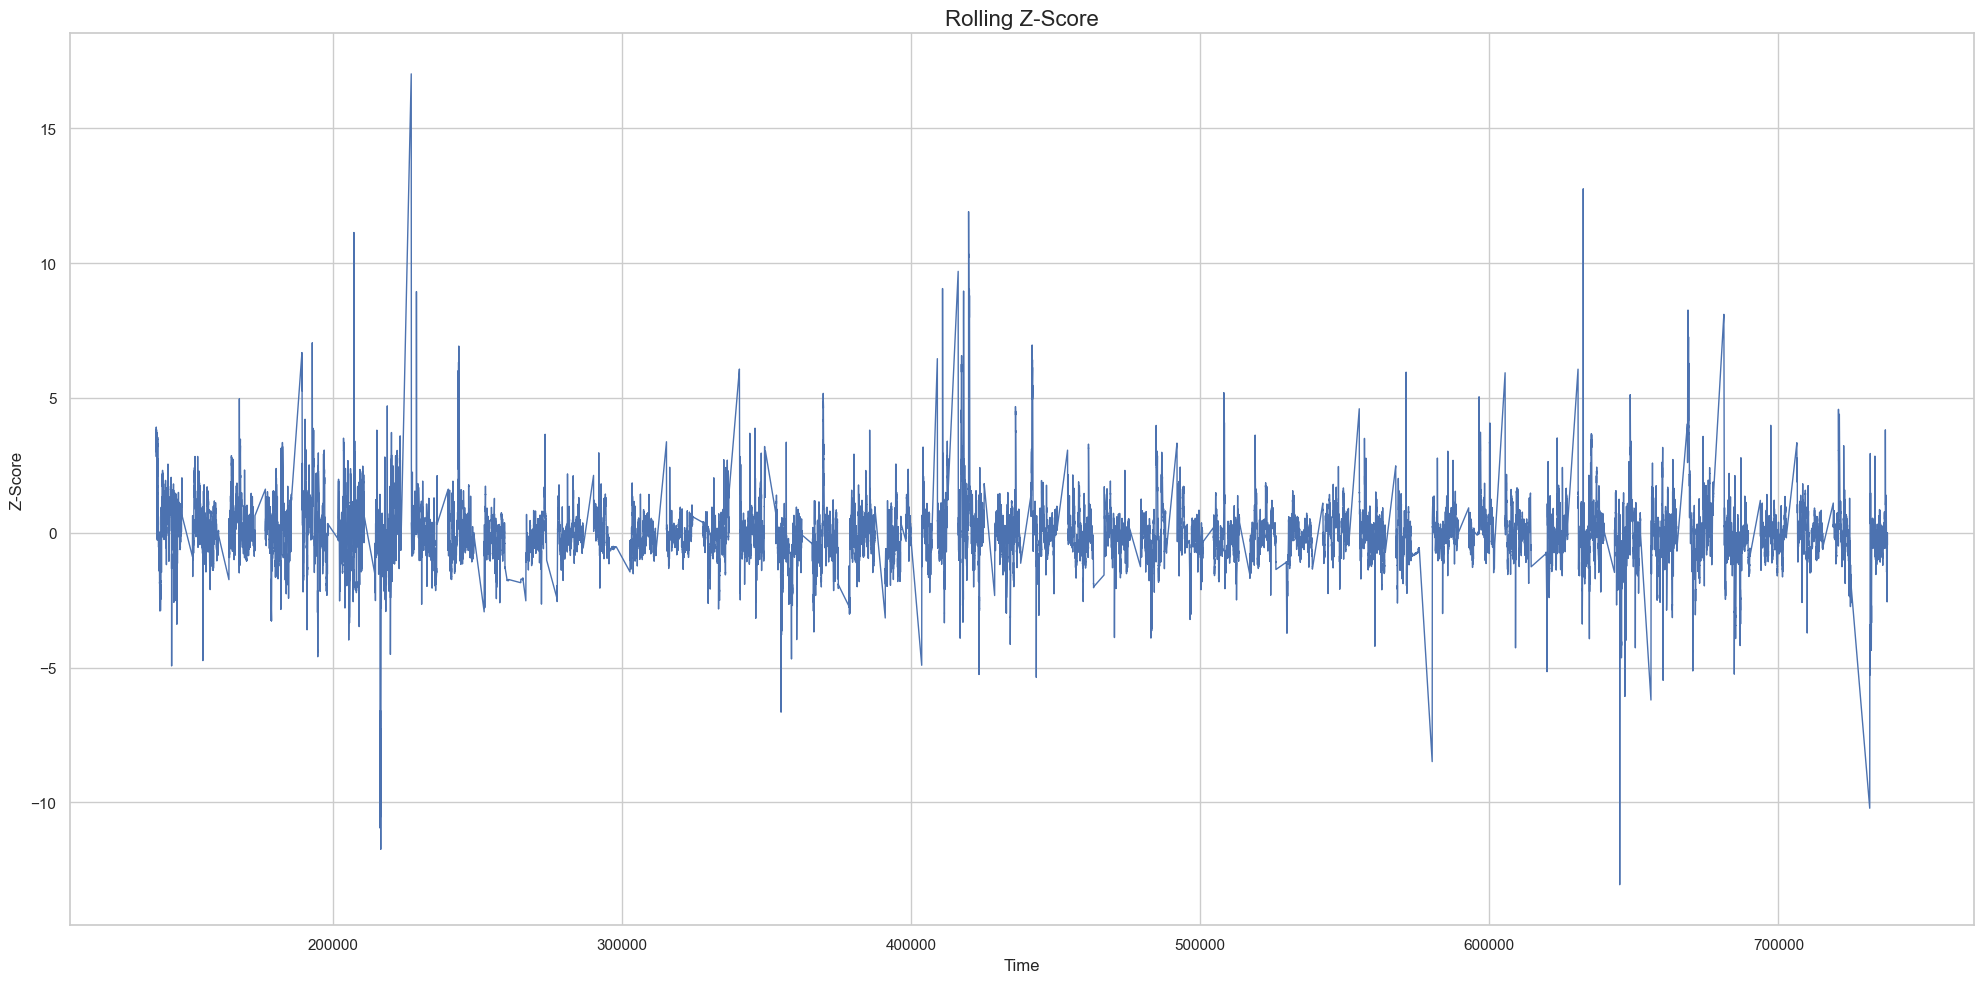

In [146]:
# Calculate spread
rolling_window = 10 * 24 * 360 #10 days
train_df['S_t'] = train_df['Y_ema'] - (train_df['alpha_ols'] + train_df['beta_ols'] * train_df['X_ema'])

rolling_mean = train_df['S_t'].rolling(rolling_window).mean()
rolling_std = train_df['S_t'] .rolling(rolling_window).std()


train_df['z_t'] = (train_df['S_t'] - rolling_mean) / rolling_std



plt.figure(figsize=(20, 10))

train_df['z_t'].plot(linewidth=1)

plt.title("Rolling Z-Score", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Z-Score", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


From the above figure, it is evident that the rolling $z$-score is highly volatile, exhibiting frequent and extreme spikes. While this increases the number of threshold crossings—and therefore the apparent number of trading opportunities—most excursions are short-lived and erratic rather than sustained mean-reverting dislocations. As such, a naive threshold-based strategy on this $z$-score is likely to overtrade, leading to higher transaction costs and potential adverse selection.

A key driver of this behaviour is the standardisation step,

$$z_t = \frac{S_t - \mu_t}{\sigma_t} $$

In particular, the rolling (or adaptive) standard deviation estimate $\sigma_t$ can occasionally become very small during low-volatility regimes. When $\sigma_t$ collapses, even modest deviations in the spread $S_t$ produce disproportionately large $z$-scores. Moreover, because we apply EMA smoothing to $X_t$ and $Y_t$, the spread process becomes mechanically less variable at high frequencies. While this can improve signal-to-noise ratio, it also reduces the short-term variance of $S_t$, which may further shrink $\sigma_t$ and amplify $z_t$ if the volatility estimator is not appropriately stabilised (e.g., via longer half-life). This is an area for further research

## Z-Score Trading Rule

We implement a mean-reversion strategy based on the standardised spread

$$
z_t = \frac{S_t - \mu_t}{\sigma_t}.
$$

We enter trades when the spread deviates significantly from its estimated equilibrium:

- **Sell $Y$ (short spread)** when  
  $$
  z_t > 1.5
  $$
  indicating the spread is sufficiently above its mean.

- **Buy $Y$ (long spread)** when  
  $$
  z_t < -1.5
  $$
  indicating the spread is sufficiently below its mean.

Under the null hypothesis that spread deviations are approximately normally distributed with mean zero and unit variance, a threshold of $|z_t| > 1.5$ corresponds to a one-sided tail probability of approximately

$$
P(Z > 1.5) \approx 6.7\%,
$$

or roughly 13.4% on a two-sided basis. Therefore, trades are triggered only when the spread moves into statistically unlikely tail regions, where mean reversion is expected.


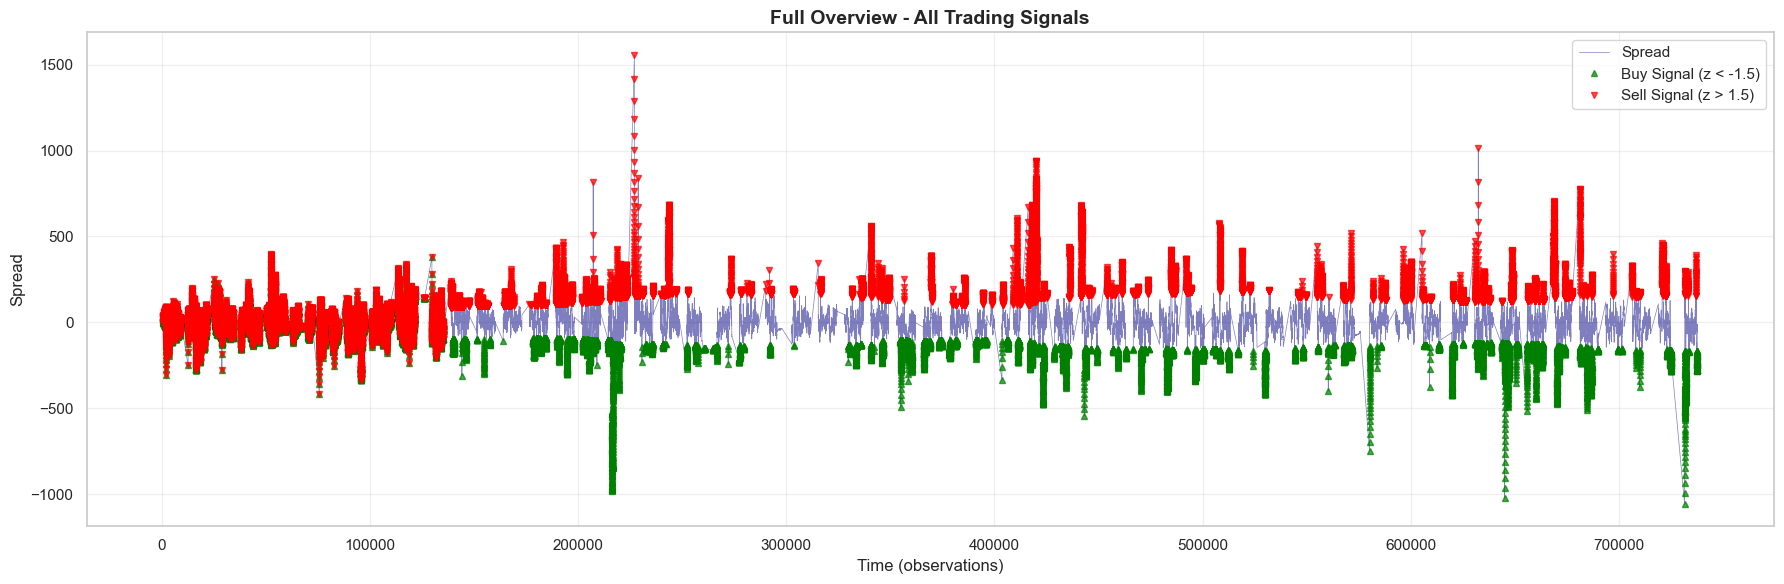

In [152]:
fig, ax = plt.subplots(figsize=(18, 6))

# Plot spread
ax.plot(train_df.index, train_df['S_t'].values, 
        linewidth=0.5, alpha=0.5, color='navy', label='Spread')

# Create buy/sell arrays
buy = train_df['S_t'].copy()
sell = train_df['S_t'].copy()

buy[train_df['z_t'] > -1.5] = np.nan
sell[train_df['z_t'] < 1.5] = np.nan

# Plot signals
ax.plot(train_df.index, buy.values,
        color='green', linestyle='None', marker='^', 
        markersize=4, label='Buy Signal (z < -1.5)', alpha=0.7)

ax.plot(train_df.index, sell.values,
        color='red', linestyle='None', marker='v', 
        markersize=4, label='Sell Signal (z > 1.5)', alpha=0.7)

ax.set_xlabel('Time (observations)', fontsize=12)
ax.set_ylabel('Spread', fontsize=12)
ax.set_title('Full Overview - All Trading Signals', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('signals_full_overview.png', dpi=150, bbox_inches='tight')
plt.show()


In [149]:
class PairsTrader:
    """
    Pairs trading strategy with dynamic hedge ratio (beta)
    Trades spread between X and Y based on z-score signals
    
    Spread = Y - β*X
    For every 1 unit of Y, we trade β units of X
    """
    
    def __init__(self, z_entry=1.5, z_exit=0.5):
        self.z_entry = z_entry
        self.z_exit = z_exit
        
        # Position tracking
        self.position = 0  # 1 = long spread, -1 = short spread, 0 = flat
        self.X_quantity = 0.0
        self.Y_quantity = 0.0
        
        # P&L tracking
        self.cash = 0.0
        self.pnl_history = []
        self.position_history = []
        
        # Trade tracking
        self.trades = []
        self.n_trades = 0
        
    def enter_long_spread(self, row, beta):
        """
        Long spread: Long Y, Short B*X
        When z < -z_entry (spread undervalued)
        """
        # Long β units of Y
        Y_price = row['Y_ASK']
        Y_qty = 1
        
        # Short 1 unit of X
        X_price = row['X_BID']
        X_qty = -beta
        
        # Update cash
        self.cash -= Y_qty * Y_price  # Pay for Y
        self.cash += abs(X_qty) * X_price  # Receive from shorting X
        
        # Update positions
        self.Y_quantity += Y_qty
        self.X_quantity += X_qty
        self.position = 1
        
        self.trades.append({
            'time': row.name,
            'action': 'LONG_SPREAD',
            'X_qty': X_qty,
            'X_price': X_price,
            'Y_qty': Y_qty,
            'Y_price': Y_price,
            'beta': beta,
            'z_score': row.get('z_t', np.nan)
        })
        self.n_trades += 1
        
    def enter_short_spread(self, row, beta):
        """
        Short spread: Short Y, Long B*X
        When z > z_entry (spread overvalued)
        """
        # Short β units of Y
        Y_price = row['Y_BID']
        Y_qty = -1
        
        # Long 1 unit of X
        X_price = row['X_ASK']
        X_qty = beta
        
        # Update cash
        self.cash += abs(Y_qty) * Y_price  # Receive from shorting Y
        self.cash -= X_qty * X_price  # Pay for X
        
        # Update positions
        self.Y_quantity += Y_qty
        self.X_quantity += X_qty
        self.position = -1
        
        self.trades.append({
            'time': row.name,
            'action': 'SHORT_SPREAD',
            'X_qty': X_qty,
            'X_price': X_price,
            'Y_qty': Y_qty,
            'Y_price': Y_price,
            'beta': beta,
            'z_score': row.get('z_t', np.nan)
        })
        self.n_trades += 1
        
    def exit_position(self, row):
        """Close all positions"""
        if self.position == 0:
            return
        
        # Close Y
        if self.Y_quantity > 0:
            self.cash += self.Y_quantity * row['Y_BID']
        elif self.Y_quantity < 0:
            self.cash -= abs(self.Y_quantity) * row['Y_ASK']
        
        # Close X
        if self.X_quantity > 0:
            self.cash += self.X_quantity * row['X_BID']
        elif self.X_quantity < 0:
            self.cash -= abs(self.X_quantity) * row['X_ASK']
        
        self.trades.append({
            'time': row.name,
            'action': 'EXIT',
            'X_qty': -self.X_quantity,
            'X_price': row['X_BID'] if self.X_quantity > 0 else row['X_ASK'],
            'Y_qty': -self.Y_quantity,
            'Y_price': row['Y_BID'] if self.Y_quantity > 0 else row['Y_ASK'],
            'beta': np.nan,
            'z_score': row.get('z_t', np.nan)
        })
        self.n_trades += 1
        
        # Reset
        self.X_quantity = 0.0
        self.Y_quantity = 0.0
        self.position = 0
        
    def calculate_unrealized_pnl(self, row):
        """Mark-to-market P&L"""
        unrealized = 0.0
        
        if self.Y_quantity > 0:
            unrealized += self.Y_quantity * row['Y_BID']
        elif self.Y_quantity < 0:
            unrealized -= abs(self.Y_quantity) * row['Y_ASK']
        
        if self.X_quantity > 0:
            unrealized += self.X_quantity * row['X_BID']
        elif self.X_quantity < 0:
            unrealized -= abs(self.X_quantity) * row['X_ASK']
        
        return self.cash + unrealized
        
    def run(self, data):
        """Run backtest"""
        for i in range(len(data)):
            row = data.iloc[i]
            
            if pd.isna(row.get('z_t')) or pd.isna(row.get('beta_ols')):
                self.pnl_history.append(self.calculate_unrealized_pnl(row))
                self.position_history.append(self.position)
                continue
            
            z = row['z_t']
            beta = row['beta_ols']
            alpha = row['alpha_ols']
            
            # Trading logic
            if self.position == 0:
                if z < -self.z_entry:
                    self.enter_long_spread(row, beta)
                elif z > self.z_entry:
                    self.enter_short_spread(row, beta)
            else:
                if abs(z) < self.z_exit:
                    self.exit_position(row)
            
            self.pnl_history.append(self.calculate_unrealized_pnl(row))
            self.position_history.append(self.position)
        
        # Force exit
        if self.position != 0:
            self.exit_position(data.iloc[-1])
            
        return {
            'final_pnl': self.pnl_history[-1],
            'n_trades': self.n_trades,
            'pnl_history': self.pnl_history,
            'position_history': self.position_history,
            'trades': pd.DataFrame(self.trades)
        }

# Run it
trader = PairsTrader(z_entry= 1.5, z_exit=0.5)
results = trader.run(train_df)

print(f"Final P&L: ${results['final_pnl']:.2f}")
print(f"Trades: {results['n_trades']}")

Final P&L: $711438.41
Trades: 880


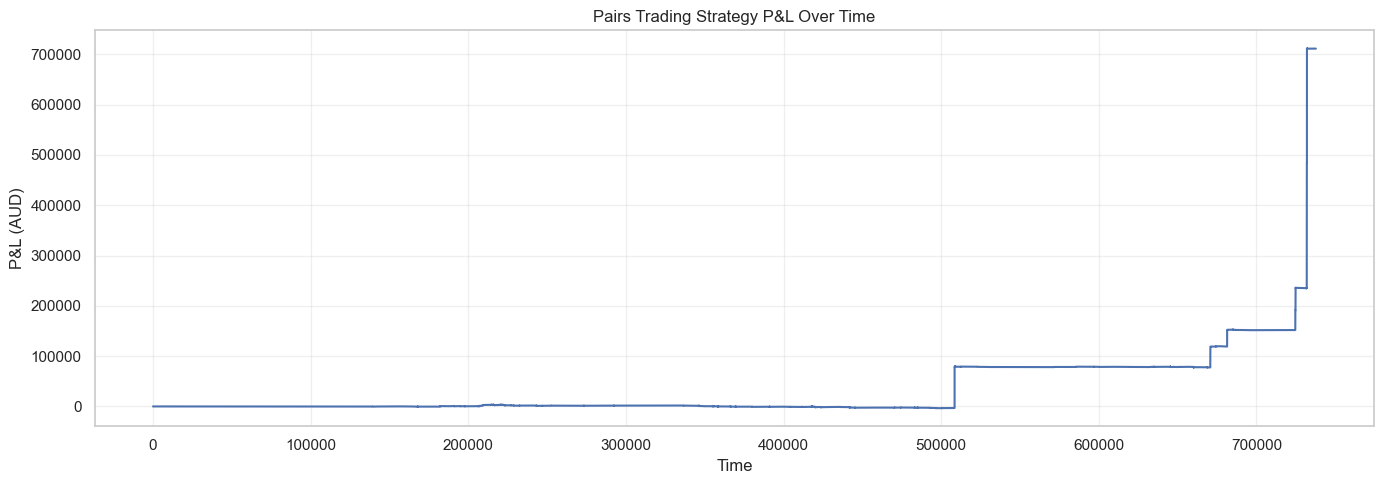

In [151]:
pnl = pd.Series(results["pnl_history"], index=train_df.index[:len(results["pnl_history"])], name="PnL")

plt.figure(figsize=(14,5))
plt.plot(pnl.index, pnl.values)
plt.xlabel("Time")
plt.ylabel("P&L (AUD)")
plt.title("Pairs Trading Strategy P&L Over Time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Pairs Trading Backtest Framework

We implement a dynamic pairs trading strategy using a time-varying hedge ratio $\beta_t$ estimated via rolling OLS.

The spread is defined as:

$$
S_t = Y_t - \beta_t X_t,
$$

and trades are triggered based on the z-score:

$$
z_t = \frac{S_t - \mu_t}{\sigma_t}.
$$

---

## Entry Rules

The strategy trades one unit of $Y$ and $\beta_t$ units of $X$ to maintain hedge neutrality.

- **Long Spread (Buy $Y$, Sell $\beta_t X$)**  
  Triggered when:
  $$
  z_t < -1.5
  $$

- **Short Spread (Sell $Y$, Buy $\beta_t X$)**  
  Triggered when:
  $$
  z_t > 1.5
  $$


---

## Exit Rule

Positions are closed when:

$$
|z_t| < 0.5
$$

indicating that the spread has reverted toward its mean.

---

Although the strategy appears profitable in the absence of strict capital and position constraints, the P&L curve reveals several structural concerns.

From the P&L plot, performance remains relatively flat for a substantial portion of the sample before experiencing a series of abrupt upward jumps toward the end of the period. The equity curve is highly step-like rather than smoothly compounding. This indicates that profits are concentrated in a small number of large moves rather than being generated consistently through repeated small mean-reversion trades.

Such behaviour suggests that:

- The strategy’s profitability may be driven by a few extreme spread dislocations rather than stable statistical edge.
- Position sizing and compounding effects may be amplifying late-stage gains.
- The model may be overly sensitive to volatility regime shifts.

In particular, the sharp vertical increases in P&L indicate that either:
1. Large position sizes were accumulated before a significant spread correction, or  
2. The z-score signal generated clustered entries during volatile periods.

This raises concerns regarding robustness and scalability.

## Limitations

1. **Profit Concentration Risk**  
   The majority of total P&L appears to be generated in a small number of trades. This makes the strategy vulnerable to regime changes, as removing just a few large moves could materially alter overall profitability.

2. **Unrealistic Capital Assumptions**  
   The current implementation does not enforce capital, leverage, or margin constraints. As a result, the model implicitly assumes unlimited financing capacity. In a realistic trading environment, such compounding would be restricted by margin requirements and risk limits.

3. **Volatility Sensitivity**  
   The P&L curve exhibits sudden jumps rather than gradual accumulation, suggesting that the signal may be sensitive to volatility compression followed by expansion. This behaviour may not persist out-of-sample.

4. **Lack of Risk Controls**  
   No drawdown constraints, stop-loss mechanisms, or position caps are enforced. The equity curve does not reflect potential liquidity constraints or adverse market impact.

## Interpretation

The absence of smooth growth and the presence of large discontinuous gains suggest that the signal is not yet be robust enough for deployment without further refinement in risk management, capital allocation, and execution modelling.

## Further Areas of Research



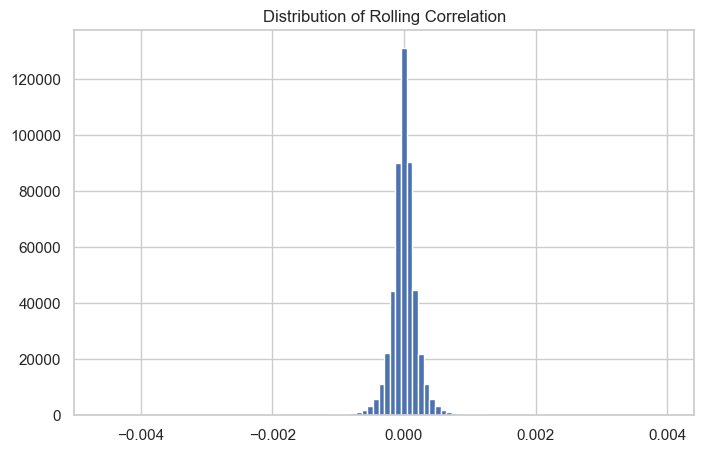

In [115]:
plt.figure(figsize=(8,5))
plt.hist(vol_df['ret_X'].dropna(), bins=100)
plt.title("Distribution of Rolling Correlation")
plt.show()

## Distributional Evaluation of Returns

The histogram of log returns appears approximately symmetric and bell-shaped, with most mass concentrated around zero and relatively thin tails. This suggests that the short-horizon return innovations may be reasonably approximated by a Gaussian distribution.

Formally, if we model the price process in log space as

$$
x_t = x_{t-1} + \varepsilon_t,
$$

then the log return

$$
r_t = x_t - x_{t-1} = \varepsilon_t
$$

represents the innovation term of the price process. The near-Gaussian shape of the empirical return distribution suggests that the innovation term $\varepsilon_t$ may be well-approximated by

$$
\varepsilon_t \sim \mathcal{N}(0, \sigma^2),
$$

at least over short intraday horizons.

From my experience in working with multi target tracking, this observation is consistent with the assumptions underlying linear Gaussian state-space models and Kalman filtering, where measurement or transition noise is typically assumed to be normally distributed. If returns are approximately Gaussian, then modelling the spread or latent equilibrium dynamics using a linear Gaussian framework becomes statistically coherent.

However, it is important to note that:

1. Visual Gaussianity does not imply true normality; formal tests (e.g., Jarque–Bera) would be required.
2. High-frequency financial returns often exhibit excess kurtosis and volatility clustering, even if the central mass appears Gaussian.
3. Even if single-period innovations are approximately normal, serial dependence in volatility may still violate i.i.d. assumptions.

Therefore, while the empirical distribution supports the plausibility of Gaussian innovation modelling, further diagnostics are required before fully adopting a linear Gaussian state-space specification.


## Further Investigation: Order Book Imbalance (OBI)

The Order Book Imbalance (OBI) is defined as

$$
OBI = \frac{BID_{vol} - ASK_{vol}}{BID_{vol} + ASK_{vol}},
$$

which measures the relative pressure between buy-side and sell-side liquidity at the top of the book. A positive OBI indicates stronger bid-side pressure (buying dominance), while a negative OBI reflects stronger ask-side pressure (selling dominance).

While the current strategy primarily relies on equilibrium deviations captured by the spread $z$-score, OBI represents a complementary microstructure signal. Unlike the spread, which reflects medium-horizon mispricing, OBI captures short-term order flow pressure and immediate liquidity imbalances.

At this stage, OBI has not been fully integrated into the trading rule. However, it presents a promising direction for further analysis. In particular, future work could examine:

- Whether OBI improves prediction of short-term spread changes,
- Whether OBI can be used as a confirmation filter for $z$-score entries,
- Whether extreme OBI values precede spread reversals or continuations,
- Whether incorporating OBI reduces false signals generated by noisy $z$-scores.

Given that OBI directly reflects supply–demand imbalance, it may enhance the robustness of the model when combined with equilibrium-based signals. A more detailed statistical analysis would be required to determine its incremental predictive value and economic significance.
